# Santander Customer Transaction Prediction Competition

## Desafio vivencial - Trilha de formação de cientistas de dados da Petrobras

"*In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.*"

Kaggle challende URL: https://www.kaggle.com/competitions/santander-customer-transaction-prediction/submit

As mentioned in the introductory competition text, the provided data *has the same structure* (distribution?) as the real data. This suggests that the data provided in synthetic and realistic, but not necessarily real.

This notebook is inspired by the following works:

* https://www.kaggle.com/code/cdeotte/200-magical-models-santander-0-920
* https://www.kaggle.com/code/whitebird/0-923-in-n-5-aug
* https://deb-sahoo19.medium.com/santander-customer-transaction-prediction-9e0edc8f9baa
* https://rstudio-pubs-static.s3.amazonaws.com/496841_bc9c66aa3ce14d55bcabdaddcf595412.html
* https://www.kaggle.com/code/navarro380/santander-eda-keras-model-logistic-reg-lasso/notebook

## Environment configuration

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Importando bibliotecas necessárias para utilizar os algoritmos de Machine Learning.

import lightgbm

import xgboost as xgb

from xgboost import XGBClassifier

from sklearn import tree

from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split

# Importando classe, para carregar e salvar modelos preditivos em arquivos externos.

import pickle

# Importando classe, para fazer a busca dos melhores parâmetros, a serem utilizados em cada um dos modelos treinados.

from sklearn.model_selection import GridSearchCV

# Importando classes, para calcular as métricas de avaliação dos modelos preditivos.

from sklearn.metrics import accuracy_score, balanced_accuracy_score, average_precision_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, cohen_kappa_score

kaggle = True

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Competition evaluation metric

Submissions are evaluated on area under the ROC curve (`AUC`) between the predicted probability and the observed target. 

This makes sense for this dataset, since, as we will see later, the distribution of the binary target variable in unbalanced.

Here is a link about AUC:

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

# 1. Reading input dataset

In [7]:
df_train = pd.read_csv(os.path.join('../input/santander-customer-transaction-prediction', 'train.csv'))
df_test = pd.read_csv(os.path.join('../input/santander-customer-transaction-prediction', 'test.csv'))

In [8]:
print(f'Train dataset has {len(df_train.index)} entries.')
print(f'Test dataset has {len(df_test.index)} entries.')

Train dataset has 200000 entries.
Test dataset has 200000 entries.


#### Comments

It is interesting to see that both train and test datasets have the same size (200k entries). 

The `df_train` dataset will be used in the whole model training process to generate the final ML model, which will be used to make predictions on the `df_test` dataset. These predictions will be sent to Kaggle through a submission csv file.

# 2. Exploratory Data Analysis (EDA)

## 2.1. Data description

We are provided with an anonymized dataset containing several numeric feature variables, the binary target column, and a string ID_code column.

The task is to predict the value of the binary **target** column in the test set.

#### Comments

Unfortunately, since the dataset is anonymized and the real column names are unknown, data analysis becomes harder and it is more difficult to work on the data and devise new (derived) features, which could help improving the model results.

In [4]:
df_train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


#### Comments

Comparing each column in the train dataset, Min, Max and Standard Deviation values are quite different. This probably indicates that the provided data is **not** standardized or normalized.

## 2.2. Checking data types and column names

Based on the info command below, we can see that the dataset is formed by an ID column called `ID_code` (`string`), the `target` column (binary, `int64`) and 200 numeric columns (real-valued, `float64`).

In [5]:
df_train.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 202 columns):
 #    Column   Non-Null Count   Dtype  
---   ------   --------------   -----  
 0    ID_code  200000 non-null  object 
 1    target   200000 non-null  int64  
 2    var_0    200000 non-null  float64
 3    var_1    200000 non-null  float64
 4    var_2    200000 non-null  float64
 5    var_3    200000 non-null  float64
 6    var_4    200000 non-null  float64
 7    var_5    200000 non-null  float64
 8    var_6    200000 non-null  float64
 9    var_7    200000 non-null  float64
 10   var_8    200000 non-null  float64
 11   var_9    200000 non-null  float64
 12   var_10   200000 non-null  float64
 13   var_11   200000 non-null  float64
 14   var_12   200000 non-null  float64
 15   var_13   200000 non-null  float64
 16   var_14   200000 non-null  float64
 17   var_15   200000 non-null  float64
 18   var_16   200000 non-null  float64
 19   var_17   200000 non-null  float64
 20   va

#### Convert float64 columns to float32 to save space

In [9]:
for col in df_train.columns:
    if col != 'ID_code' and col != 'target':
        df_train[col] = df_train[col].astype(np.float32)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), int64(1), object(1)
memory usage: 155.6+ MB


## 2.3. Checking for null values

#### Comments 

We can see that there are no null (`NaN`) values in any of the columns, neither in the train set nor in the test set.

In [7]:
df_train.isna().sum().sum()

0

In [8]:
df_test.isna().sum().sum()

0

## 2.4. Proportion of target values

Let's check if the distribution of 0 and 1 values of the target is imbalanced or not.

In [9]:
df_train_prop = df_train.groupby(by=['target']).count()
display(df_train_prop)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,,,,,,,,,,,,,,,,,,,,,
0,179902,179902,179902,179902,179902,179902,179902,179902,179902,179902,...,179902,179902,179902,179902,179902,179902,179902,179902,179902,179902
1,20098,20098,20098,20098,20098,20098,20098,20098,20098,20098,...,20098,20098,20098,20098,20098,20098,20098,20098,20098,20098


<AxesSubplot:xlabel='target'>

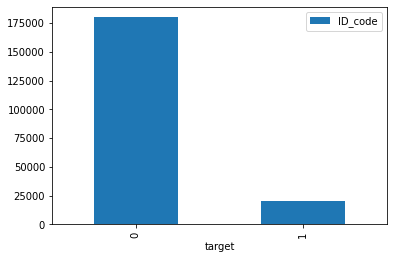

In [10]:
df_train_prop.reset_index().plot.bar(x='target', y='ID_code')

In [11]:
zero_prop = np.round(100.0 * len(df_train[df_train['target'] == 0].index) / len(df_train.index), 2)
one_prop = np.round(100.0 - zero_prop, 2)
print(f'Proportion of class 0: {zero_prop} % ; Proportion of class 1: {one_prop} %')

Proportion of class 0: 89.95 % ; Proportion of class 1: 10.05 %


#### Comments

As we can see in the graph, the target (binary) class is imbalanced, with 10.05% of the records belonging to class 1 and 89.95% belonging to class 0. In other words, there are a lot less `committed customer transactions` than the whole possible amount. 

## 2.5. Correlation analysis

Inspired by: 
* https://www.kaggle.com/code/xuanzhihuang/santander-customer-transaction-prediction-lgbm
* https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

Correlation analysis can help us identify the degree of importance of each feature. It can also help us later during feature selection, when we want to find the best set of features to build the ML model.



### 2.5.0. Feature scaling

Many of the feature selection algorithms we'll use later are sensitive to the magnitude of each feature. Therefore it is important to apply feature scaling on all X columns.

The use of the StandardScaler will not affect the values of correlation.

#### a) Before scaling

Before applying StandardScaler, let's observe the distribution of values of the provided features, to see the different range differences.
These differences may affect the training of many algorithms, such as Neural Networks.

In [10]:
X = df_train.drop(["ID_code", "target"], axis = 1)
y = df_train['target']

<AxesSubplot:title={'center':'Non standarized values'}>

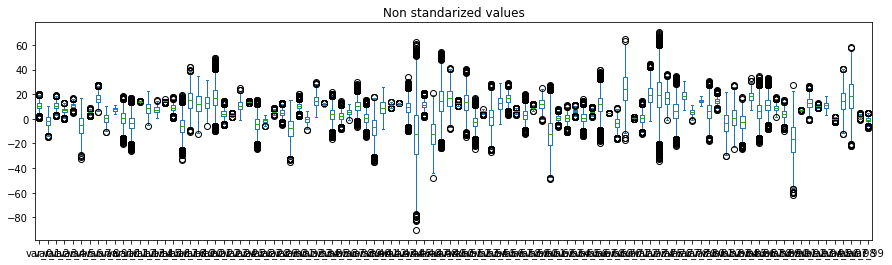

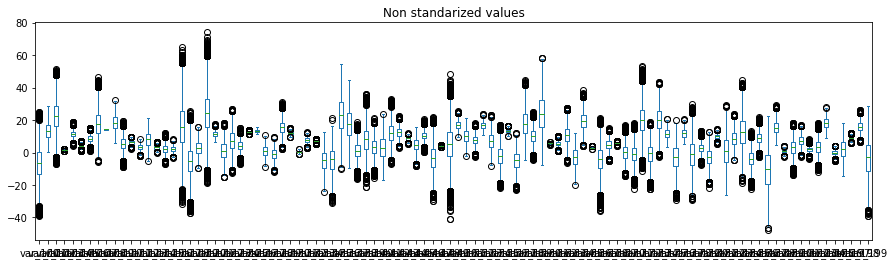

In [13]:
X[X.columns[:100]].plot(kind='box', figsize=[15,4], title='Non standarized values')
X[X.columns[100:]].plot(kind='box', figsize=[15,4], title='Non standarized values')

**We can observe, in the blox plot value range, that there are no absurd values, such as -999999. So we don't need to investigate the replacement of these outlier values.**

**The differences between featues can also be observed through a distribution plot where each curve represents the distribution of values of each feature**

Text(0, 0.5, 'Density')

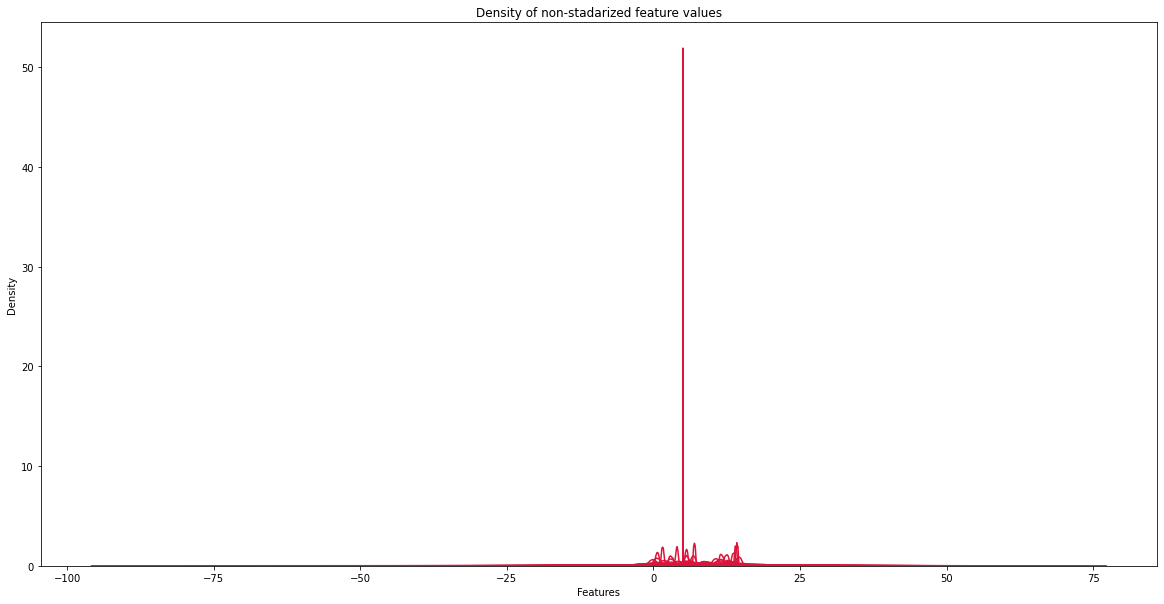

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
for val in X:
    sns.kdeplot(data=X[val], color='crimson', label=val, fill=False, ax=ax)
# end for

plt.title('Density of non-stadarized feature values')
plt.xlabel('Features')
plt.ylabel('Density')

**It is also very interesting to obseve the different magnitudes among the maximum value observed for each feature**

In [15]:
val_max = pd.DataFrame(data=X.max(), columns=['max'])
val_max['var'] = val_max.index
val_max[['var', 'max']].sort_values(by=['max'])

,var,max
var_71,var_71,1.571900
var_95,var_95,1.804000
var_103,var_103,2.188700
var_131,var_131,2.192300
var_27,var_27,3.243100
...,...,...
var_45,var_45,62.084400
var_70,var_70,64.464401
var_117,var_117,64.810898
var_74,var_74,70.272003


<AxesSubplot:title={'center':'Max values distribution'}>

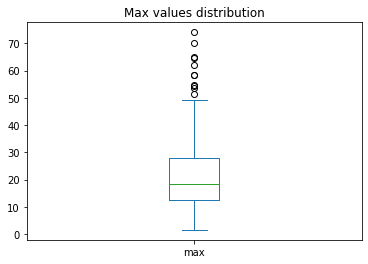

In [16]:
val_max['max'].plot(kind='box', title='Max values distribution')

#### b) Applying StandardScaler to features

**Note: before applying StandardScaler, it is important to split our dataset into train and test data, so that the scaling on train data does not interfere the scaling of test data and vice-versa. Let's do that now. We'll split the data in the proportion of 75% x 25%.**

In [11]:
# Randomly split train and test data
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size=0.25, random_state=42)

In [12]:
X_train = train.drop(["ID_code", "target"], axis = 1)
X_test = test.drop(["ID_code", "target"], axis = 1)
y_train = train['target']
y_test = test['target']

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
X_train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,-0.619776,1.606082,0.438447,0.435669,0.407444,-0.531065,-0.426813,-1.933518,0.767661,-0.042011,...,-0.241713,1.064855,-2.002666,-0.002643,0.773100,-0.430426,-2.364699,-0.014185,-0.142153,0.132483
1,0.760278,-0.502921,-0.411587,-0.418000,0.326635,-1.046363,0.316915,0.339541,-1.674718,1.914493,...,1.233271,0.282418,0.827253,0.176424,0.413514,-0.703804,-1.157045,-1.887285,1.373792,-1.062553
2,0.705314,1.259040,-2.075846,0.587477,-0.263656,0.352746,0.356982,-0.092903,0.793481,0.004931,...,-0.671990,0.829430,-0.034000,-0.051798,0.429294,-0.355366,0.976296,-0.647279,-0.542005,-1.583196
3,1.080609,-0.633043,-0.092421,-0.497591,0.410708,-0.642939,-0.105351,0.849133,-0.817027,0.844623,...,-1.279045,0.611663,1.361850,-1.342431,1.537350,0.588308,-2.351933,0.154220,-1.371356,-1.237611
4,-1.266432,0.796869,0.965787,-0.054960,0.408368,0.638716,-0.122210,0.387502,0.655222,-1.290502,...,-0.149494,-0.466222,-0.136009,-0.958604,0.510742,-2.214032,1.247144,1.100114,1.072409,0.401556


#### c) After scaling

Now we can observe similar data ranges on all features.

<AxesSubplot:title={'center':'Standarized values'}>

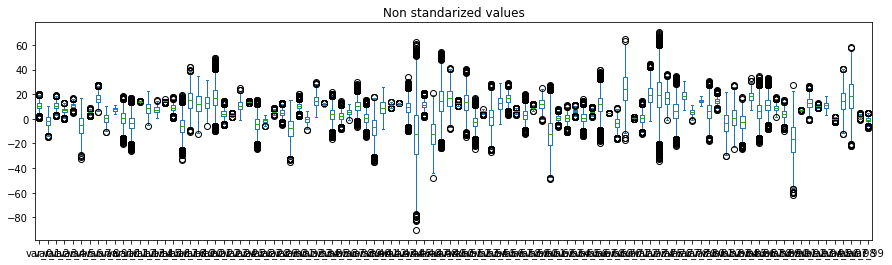

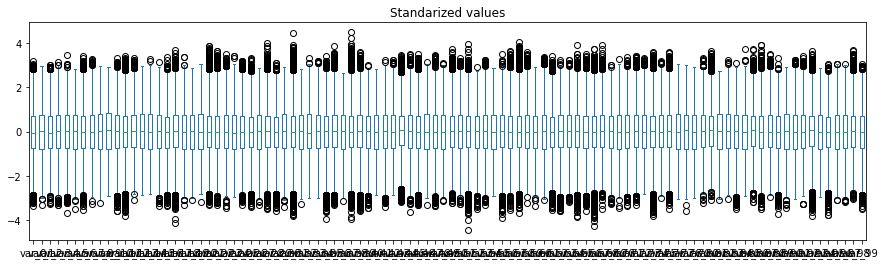

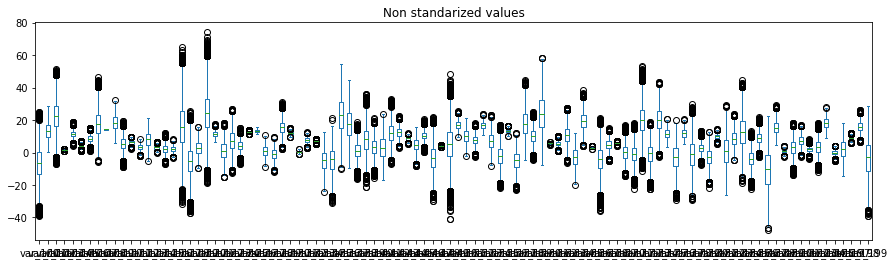

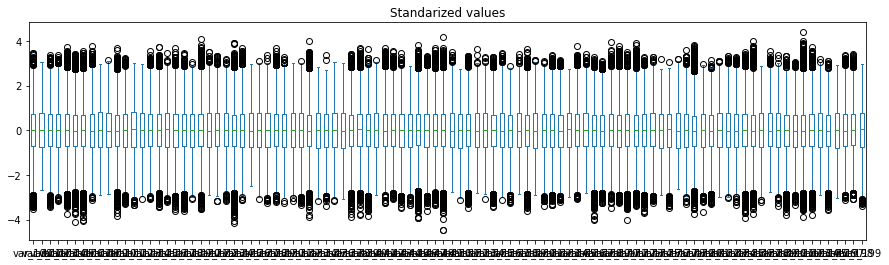

In [20]:
X[X.columns[:100]].plot(kind='box', figsize=[15,4], title='Non standarized values')
X_train[X_train.columns[:100]].plot(kind='box', figsize=[15,4], title='Standarized values')
X[X.columns[100:]].plot(kind='box', figsize=[15,4], title='Non standarized values')
X_train[X_train.columns[100:]].plot(kind='box', figsize=[15,4], title='Standarized values')

**Once again, let's see the distribution plot where each curve represents the distribution of values of each feature**

Text(0, 0.5, 'Density')

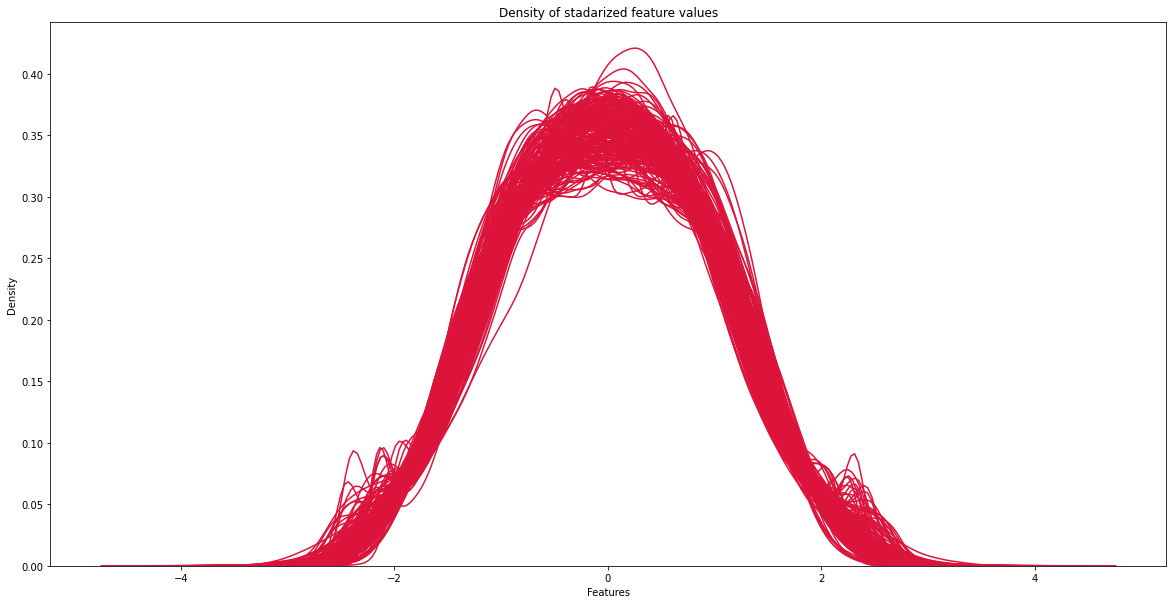

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
for val in X:
    sns.kdeplot(data=X_train[val], color='crimson', label=val, fill=False, ax=ax)
# end for

plt.title('Density of stadarized feature values')
plt.xlabel('Features')
plt.ylabel('Density')

<AxesSubplot:title={'center':'Max values distribution - standardized values'}>

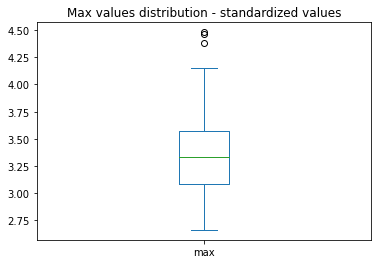

In [22]:
val_max_std = pd.DataFrame(data=X_train.max(), columns=['max'])
val_max_std['var'] = val_max_std.index
val_max_std['max'].plot(kind='box', title='Max values distribution - standardized values')

### 2.5.1. Obtain the correlation coefficient between different features

Correlation is a measure of the linear relationship of 2 or more variables. 
The logic behind using correlation for feature selection is that the good variables are highly correlated with the target. 

**Furthermore, variables should be correlated with the target but should be uncorrelated among themselves. The main idea is that, if two variables are highly correlated, we can predict one from the other. Therefore, if two features are correlated, the model only really needs one of them, as the second one does not add additional information.**

### 2.5.1.a. Pearson correlation coefficient

Let's try the Pearson correlation coefficient first.

In [23]:
# Correlation matrix
cor = df_train.drop(["ID_code"], axis = 1).corr()

In [24]:
correlations = cor.abs().unstack().sort_values(kind = "quicksort", ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

,level_0,level_1,0
201,target,var_81,0.080917
202,var_81,target,0.080917
203,target,var_139,0.074080
204,var_139,target,0.074080
205,target,var_12,0.069489
206,var_12,target,0.069489
207,target,var_6,0.066731
208,var_6,target,0.066731
209,target,var_110,0.064275
210,var_110,target,0.064275


In [25]:
correlations[(correlations['level_0'] != 'target') & (correlations['level_1'] != 'target')].head(4)

,level_0,level_1,0
523,var_139,var_26,0.009844
524,var_26,var_139,0.009844
525,var_53,var_148,0.009788
526,var_148,var_53,0.009788


#### Comments

We can see that the highest correlations found between different features are really small (max value found was `0.080917` between the target and `var_81`, and the highest correlation found between features was `0.009844`). 

**Therefore, there are no perfectly correlated features (redundant features, with absolute correlation value equal to 1) to be excluded.**

Let's now check the correlations between target variable and features.

#### Correlation heatmap

The correlation heatmap below confirms what we found in the correlation list above: all correlations have near-zero values.

If we had found predictor variables / features correlated among themselves, we would be able to drop the variable which had a lower correlation coefficient value with the target variable. But that is not the case.

<AxesSubplot:>

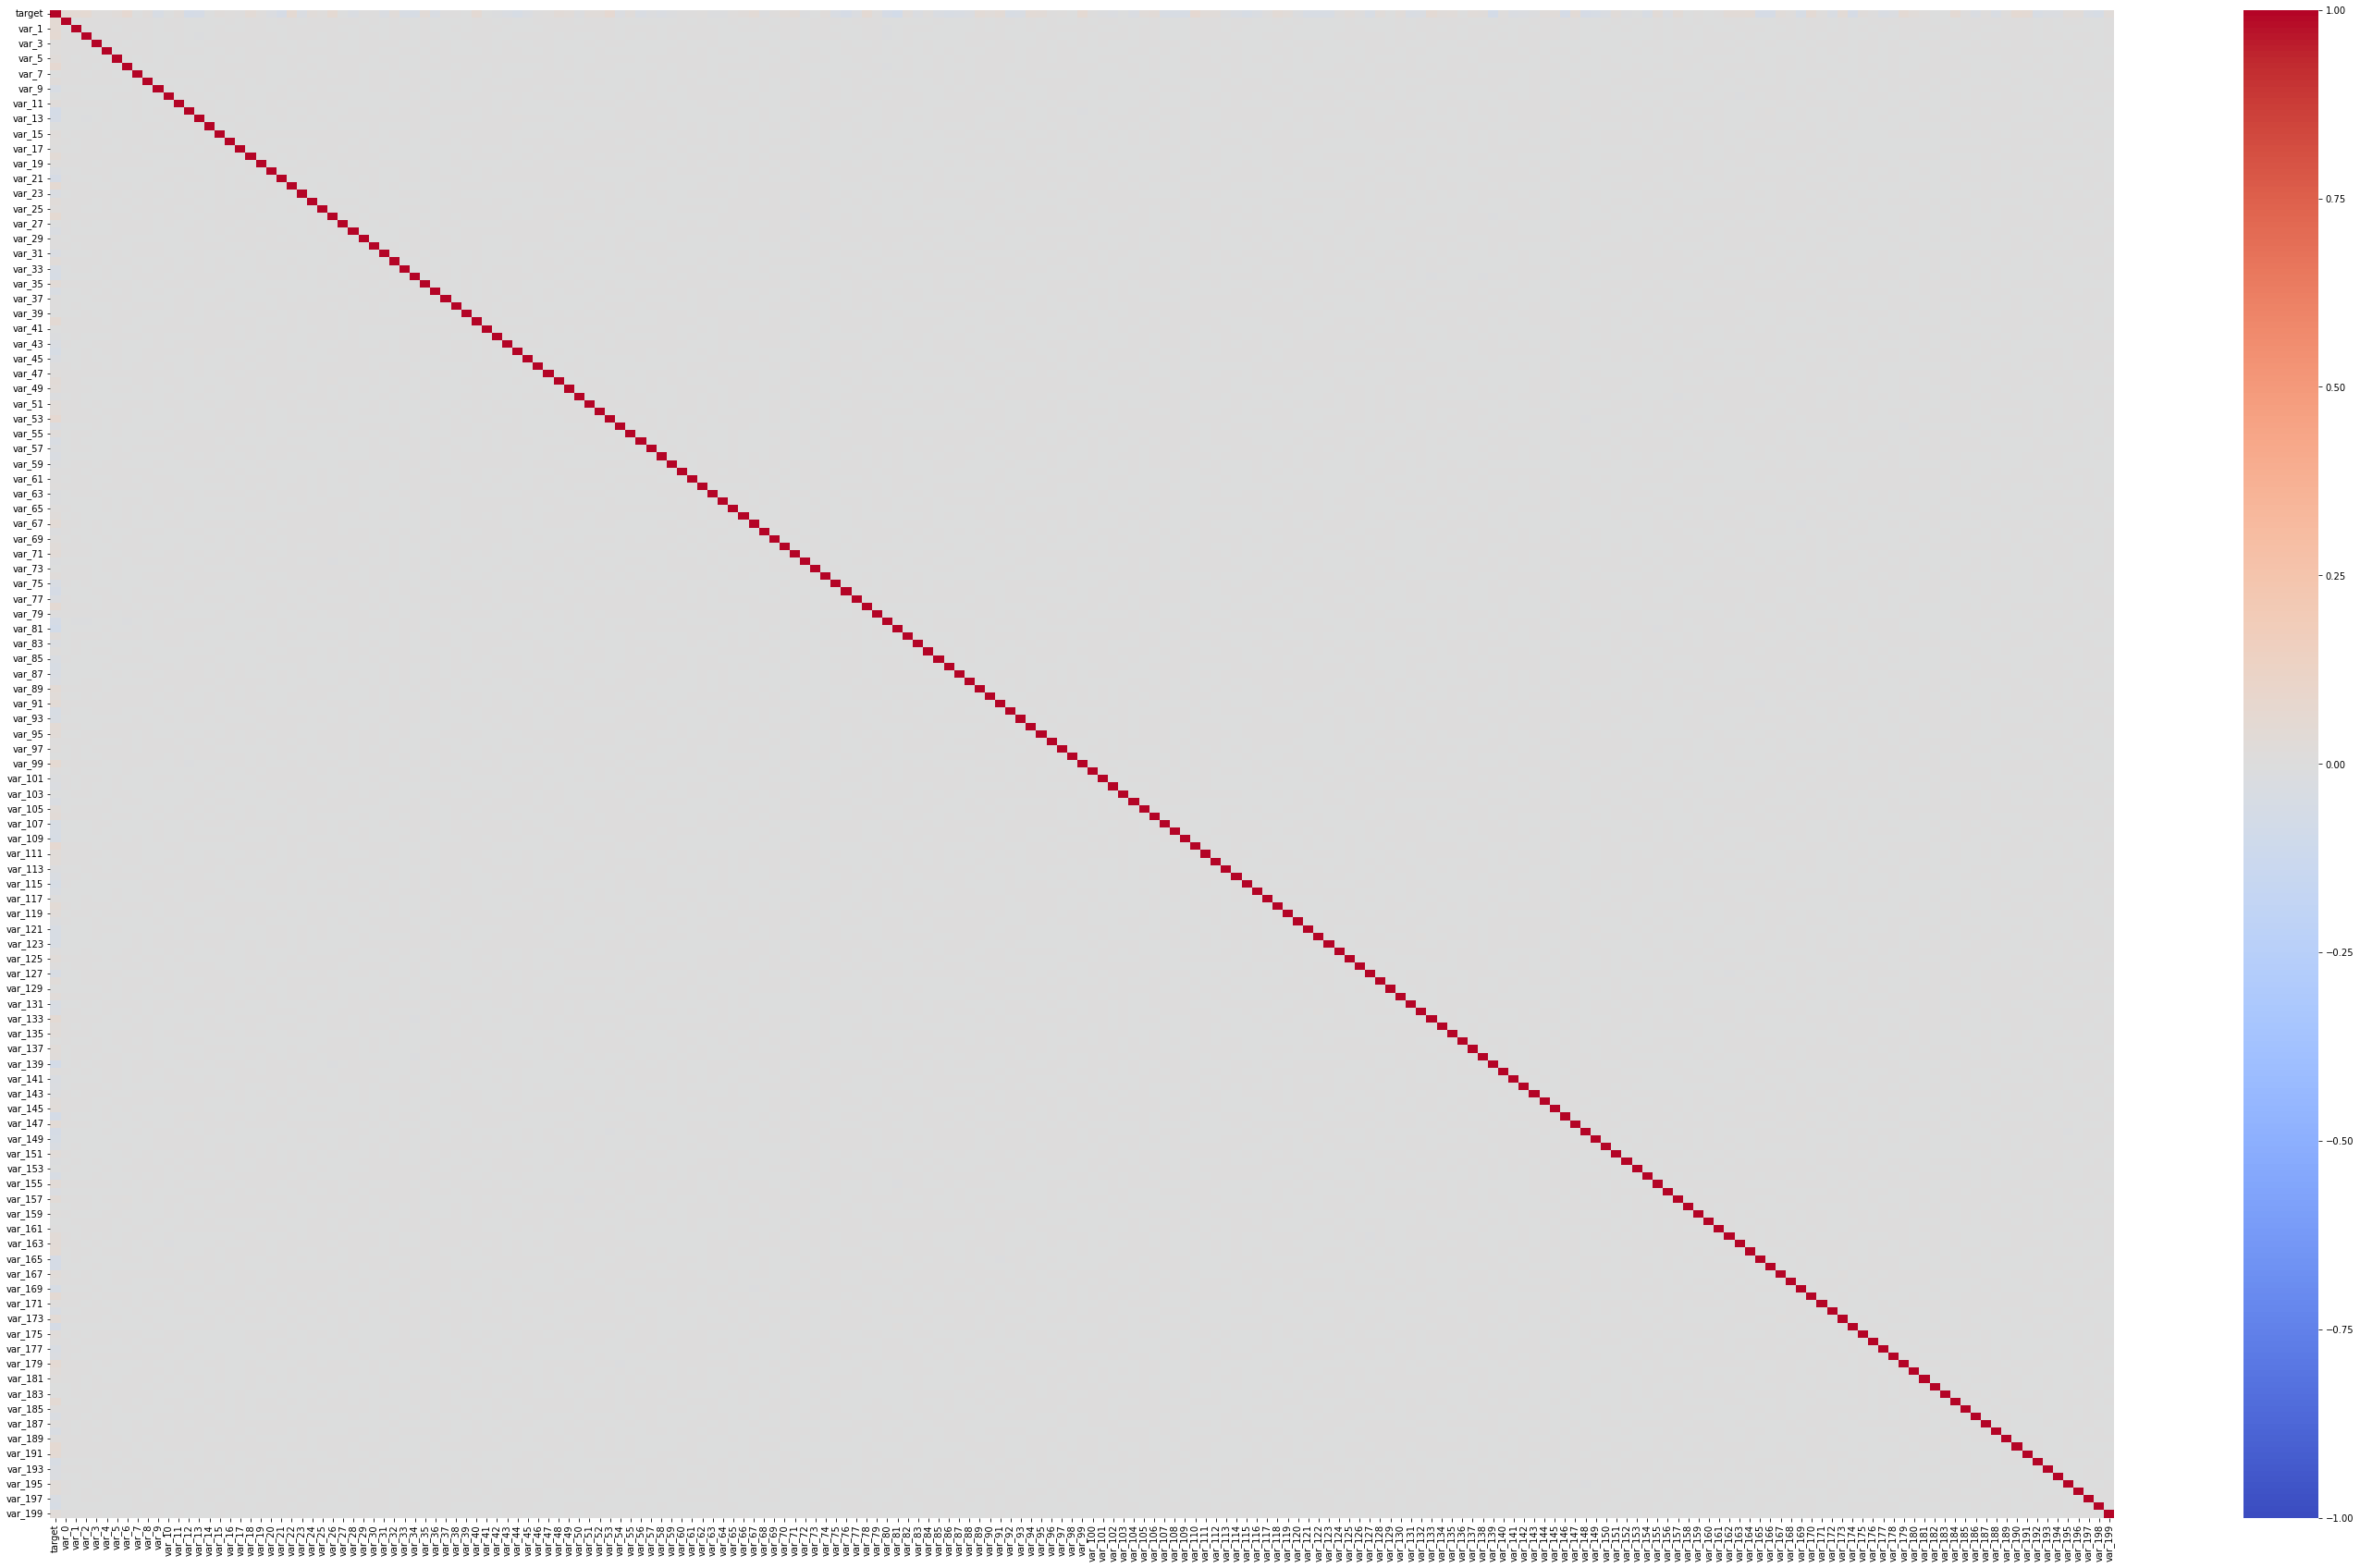

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting heatmap
plt.figure(figsize=(50,30))
sns.heatmap(cor, vmin = -1, vmax = +1, cmap = 'coolwarm')  # annot = True, 

#### Let's try the other two types of correlation, besides perason

* pearson : standard correlation coefficient

* kendall : Kendall Tau correlation coefficient

* spearman : Spearman rank correlation

In [27]:
cor_kendall = df_train.drop(["ID_code"], axis = 1).corr(method='kendall')
cor_spearman = df_train.drop(["ID_code"], axis = 1).corr(method='spearman')

In [28]:
correlations_kendall = cor_kendall.abs().unstack().sort_values(kind = "quicksort", ascending=False).reset_index()
correlations_kendall = correlations_kendall[correlations_kendall['level_0'] != correlations_kendall['level_1']]
correlations_kendall.head(10)

,level_0,level_1,0
201,var_81,target,0.057178
202,target,var_81,0.057178
203,target,var_139,0.055769
204,var_139,target,0.055769
205,var_6,target,0.050974
206,target,var_6,0.050974
207,var_12,target,0.050415
208,target,var_12,0.050415
209,target,var_110,0.047739
210,var_110,target,0.047739


In [29]:
correlations_kendall[(correlations_kendall['level_0'] != 'target') & (correlations_kendall['level_1'] != 'target')].head(4)

,level_0,level_1,0
531,var_26,var_139,0.006452
532,var_139,var_26,0.006452
533,var_183,var_189,0.006265
534,var_189,var_183,0.006265


#### Conclusion: Kendall correlations remain low (less than `0.06`).

In [30]:
correlations_spearman = cor_spearman.abs().unstack().sort_values(kind = "quicksort", ascending=False).reset_index()
correlations_spearman = correlations_spearman[correlations_spearman['level_0'] != correlations_spearman['level_1']]
display(correlations_spearman.head(10))
correlations_spearman[(correlations_spearman['level_0'] != 'target') & (correlations_spearman['level_1'] != 'target')].head(4)

,level_0,level_1,0
201,var_81,target,0.070028
202,target,var_81,0.070028
203,target,var_139,0.068302
204,var_139,target,0.068302
205,var_6,target,0.062429
206,target,var_6,0.062429
207,var_12,target,0.061740
208,target,var_12,0.061740
209,target,var_110,0.058467
210,var_110,target,0.058467


,level_0,level_1,0
519,var_139,var_26,0.009682
520,var_26,var_139,0.009682
525,var_183,var_189,0.009399
526,var_189,var_183,0.009399


#### Conclusion: Spearman correlations remain low (less than `0.07`).

### 2.5.2. Obtain the correlations between (categorical) target and (continuous) features

There are three big-picture methods to understand if a continuous and categorical are significantly correlated — point biserial correlation, logistic regression, and Kruskal Wallis H Test.

Reference: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

#### a) Point biserial Correlation

* Similar to the Pearson coefficient, the point biserial correlation can range from -1 to +1.
* The point biserial calculation assumes that the continuous variable is normally distributed and homoscedastic.
* If the dichotomous variable is artificially binarized, i.e. there is likely continuous data underlying it, biserial correlation is a more apt measurement of similarity. There is a simple formula to calculate the biserial correlation from point biserial correlation, but nonetheless this is an important point to keep in mind.

#### b) Logistic Regression

The idea behind using logistic regression to understand correlation between variables is actually quite straightforward and follows as such: If there is a relationship between the categorical and continuous variable, we should be able to construct an accurate predictor of the categorical variable from the continuous variable. If the resulting classifier has a high degree of fit, is accurate, sensitive, and specific we can conclude the two variables share a relationship and are indeed correlated.

There are a number of positive things about this approach. Logistic regression does not make many of the key assumptions of linear regression and other models that are based on least squares algorithms — particularly regarding linearity, normality, homoscedasticity, and measurement level.

#### c) Kruskal-Wallis H Test (Or parametric forms such as t-test or ANOVA)

(Estimate variance explained in continuous variable using the discrete variable)

The final family of methods to estimate association between a continuous and discrete variable rely on estimating the variance of the continuous variable, which can be explained through the categorical variable. 
There are many ways to do this. A simple approach could be to group the continuous variable using the categorical variable, measure the variance in each group and comparing it to the overall variance of the continuous variable. If the variance after grouping falls down significantly, it means that the categorical variable can explain most of the variance of the continuous variable and so the two variables likely have a strong association. If the variables have no correlation, then the variance in the groups is expected to be similar to the original variance.

### Let's use the first option

#### a.1) Point Biserial Correlation - First option of calculation

If a categorical variable only has two values (i.e. true/false), then we can convert it into a numeric datatype (0 and 1). Since it becomes a numeric variable, we can find out the correlation using the dataframe.corr() function. That is exactly our case!

In [31]:
variables = X.columns.values.tolist()
variables[0:5]

['var_0', 'var_1', 'var_2', 'var_3', 'var_4']

In [32]:
np.corrcoef(df_train['var_0'],y)

array([[1.        , 0.05238959],
       [0.05238959, 1.        ]])

In [33]:
corr_feature_target = np.zeros(len(variables))
# let's store the correlation between each feature df_train[var] and the target df_train['target'], accessing the element [0, 1] from the corr matrix
for i, var in enumerate(variables):
    corr_feature_target[i] = np.corrcoef(df_train[var], y)[0, 1]

In [34]:
corr_feature_target = abs(pd.DataFrame(corr_feature_target))
corr_feature_target.columns = ['corr_feature_target']
corr_feature_target.sort_values(by = 'corr_feature_target')

,corr_feature_target
185,0.000053
27,0.000582
30,0.000638
17,0.000864
38,0.000970
...,...
110,0.064275
6,0.066731
12,0.069489
139,0.074080


#### a.2) Point Biserial Correlation - Second option of calculation

Source: https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1

SciPy conveniently has a point biserial correlation function called pointbiserialr.

The point biserial correlation is used to measure the relationship between a binary variable, `x`, and a continuous variable, `y`.

In [35]:
from scipy.stats import pointbiserialr

pbc = dict()

for col in df_train.columns:
    if col != 'target' and col != 'ID_code':
        pbc_ = pointbiserialr(x=df_train['target'], y=df_train[col])
        pbc[col] = pbc_
# end for
df_pbc = pd.DataFrame.from_dict(pbc, orient='index', columns=['correlation', 'p-value'])
df_pbc['correlation_abs'] = np.abs(df_pbc['correlation'])
df_pbc.sort_values(by=['correlation_abs'], ascending=False, inplace=True)
df_pbc

,correlation,p-value,correlation_abs
var_81,-0.080917,1.126150e-287,0.080917
var_139,-0.074080,2.486494e-241,0.074080
var_12,-0.069489,1.558996e-212,0.069489
var_6,0.066731,4.028138e-196,0.066731
var_110,0.064275,4.490794e-182,0.064275
...,...,...,...
var_38,0.000970,6.645166e-01,0.000970
var_17,0.000864,6.992989e-01,0.000864
var_30,0.000638,7.754185e-01,0.000638
var_27,-0.000582,7.946877e-01,0.000582


#### Comments

Both methods used to calculate the Point Biserial Correlation yielded the same results.

The correlations between target variable and features are also **small**. The largest correlation observed was `0.080917`.  

**We will not use the other methods (b) and (c) to establish the correlation between the features and the target variable because Point Biserial (a) is the preferred method to do so when the categorical feature is binary.**

### 2.5.X. Detecting duplicate rows

In [36]:
# Checking for duplicate rows
X.duplicated().sum()

0

No duplicate rows found.

## 2.6. Feature selection

Source: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

Let's select the most important features.

Using a feature selection metric, it is possible to choose a subset of the input variables most related to the output variable.

Classification Feature Selection:
(Numerical Input, Categorical Output)

### 2.6.1. Information gain

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

In [15]:
from sklearn.feature_selection import mutual_info_classif
if kaggle:
    df_information_gain = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_information_gain.pkl')
elif os.path.exists('df_information_gain.pkl.gz'):
    df_information_gain = pd.read_pickle('df_information_gain.pkl.gz')
else:
    importances = mutual_info_classif(X_train, y_train)
    feature_importances = pd.Series(importances, X_train.columns)
    feature_importances.sort_values(ascending=False, inplace=True)
    df_information_gain = pd.DataFrame(data={'information_gain': feature_importances}).reset_index()
    df_information_gain.to_pickle('df_information_gain.pkl.gz')

In [16]:
feature_list = df_information_gain[df_information_gain['information_gain'] > 0]
print(len(feature_list))

152


In [18]:
df_information_gain

,index,information_gain
0,var_81,0.005013
1,var_139,0.004104
2,var_12,0.004045
3,var_80,0.004042
4,var_99,0.003434
...,...,...
195,var_130,0.000000
196,var_84,0.000000
197,var_30,0.000000
198,var_79,0.000000


### 2.6.2. Fisher’s Score (disabled)

Fisher score is one of the most widely used supervised feature selection methods. The algorithm which we will use returns the ranks of the variables based on the fisher’s score in descending order. We can then select the variables as per the case.

**We were unable to apply Fisher's score due to out of memory errors.**

from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
%matplotlib inline

if kaggle:
    df_fisher_score = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_fisher_score.pkl')
elif os.path.exists('df_fisher_score.pkl.gz'):
    df_fisher_score = pd.read_pickle('df_fisher_score.pkl.gz')
else:
    # Calculating scores
    # Calculating the scores based on X_train gives out of memory error, so let's calculate based on a smaller set
    train1, test1 = train_test_split(df_train, test_size=0.1, random_state=42)
    X_train1 = train1.drop(["ID_code", "target"], axis = 1)
    y_train1 = train1['target']
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train1 = pd.DataFrame(scaler.fit_transform(X_train1), columns = X_train1.columns)

    ranks = fisher_score.fisher_score(X_train1, y_train1)

    # rank features in descending order according to score
    fisher_feature_rank = fisher_score.feature_ranking(score)
    df_fisher_score = pd.DataFrame(pd.Series(data=fisher_feature_rank, name='fisher_score')).reset_index()
    df_fisher_score.to_pickle('df_fisher_score.pkl.gz')

### 2.6.3. Variance Threshold

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.

Variance Threshold is a simple approach to eliminate features based on our expected variance within each feature. Although, there are some down-side with the Variance Threshold method. The Variance Threshold feature selection only sees the input features (X) without considering any information from the dependent variable (y). It is only useful for eliminating features for Unsupervised Modelling rather than Supervised Modelling.

**Attention**: We need to transform all of these numerical features before we use the Variance Threshold Feature Selection as the variance is affected by the numerical scale. (See: https://towardsdatascience.com/5-feature-selection-method-from-scikit-learn-you-should-know-ed4d116e4172)

With all the features on the same scale, let’s try to select only the features we want using the Variance Threshold method.

**The idea here is to eliminate Quasi-constant variables.** Quasi-constant variables are those that have the same value for the vast majority of observations in the data set. In general, these features provide little or no information for a machine learning model to be able to discriminate or predict a target variable. But there can be exceptions. So, we must be careful when removing this kind of feature.

#### Let’s say to set a thrshold for the minimum variance value.

In [19]:
from sklearn.feature_selection import VarianceThreshold

In [20]:
if kaggle:
    df_train_var_thres_bool = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_train_var_thres_bool.pkl')
elif os.path.exists('df_train_var_thres_bool.pkl.gz'):
    df_train_var_thres_bool = pd.read_pickle('df_train_var_thres_bool.pkl.gz')
else:
    # threshold = 0.1 indicates that features with a training set variance less than this threshold will be removed (they are quasi-constant features)
    vt = VarianceThreshold(threshold = 0.01)  

    # Training the model to find variables with low variance.
    vt.fit(X_train) 
    # Checking the number of variables that are not quasi-constants
    display(sum(vt.get_support()))
    v_thrshold = VarianceThreshold(threshold=1)
    v_thrshold.fit(X_train)
    df_train_var_thres_bool = pd.DataFrame(pd.Series(data=v_thrshold.get_support(), name='train_var_thres_bool')).reset_index()
    df_train_var_thres_bool.to_pickle('df_train_var_thres_bool.pkl.gz')
    # get a list of features with variance == 1
    df_train_var_thres_bool = X_train.loc[:, v_thrshold.get_support()]
    df_train_var_thres_bool.columns

In [22]:
df_train_var_thres_bool

,index,train_var_thres_bool
0,0,False
1,1,False
2,2,True
3,3,False
4,4,False
...,...,...
195,195,True
196,196,True
197,197,False
198,198,False


### 2.6.4. Mean Absolute Difference (MAD)

The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant. This means that higher the MAD, higher the discriminatory power.

In [23]:
if kaggle:
    df_mean_abs_diff = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_mean_abs_diff.pkl')
elif os.path.exists('df_mean_abs_diff.pkl.gz'):
    df_mean_abs_diff = pd.read_pickle('df_mean_abs_diff.pkl.gz')
else:
    # Calculate MAD
    mean_abs_diff = np.sum(np.abs(X_train - np.mean(X_train, axis=0)), axis=0) / X_train.shape[0]
    # Rank the features by MAD value, descending order
    df_mean_abs_diff = pd.DataFrame(pd.Series(data=mean_abs_diff, name='mean_abs_diff')).reset_index()
    df_mean_abs_diff.sort_values(by=['mean_abs_diff'], ascending=False, inplace=True)
    df_mean_abs_diff.to_pickle('df_mean_abs_diff.pkl.gz')
# end if

In [24]:
df_mean_abs_diff.head(10)

,index,mean_abs_diff
8,var_8,0.842564
177,var_177,0.842480
77,var_77,0.842128
20,var_20,0.841513
160,var_160,0.839754
9,var_9,0.839721
112,var_112,0.839537
196,var_196,0.838387
24,var_24,0.838115
136,var_136,0.838077


array([[<AxesSubplot:title={'center':'mean_abs_diff'}>]], dtype=object)

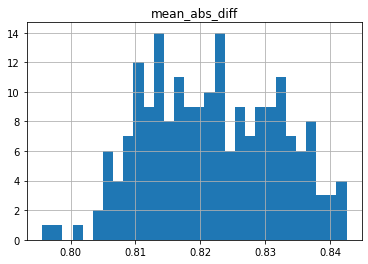

In [25]:
df_mean_abs_diff.hist(column='mean_abs_diff', bins=30)

### 2.6.5. Dispersion ratio

Another measure of dispersion applies the arithmetic mean (AM) and the geometric mean (GM).
Higher dispersion implies a higher value of Ri, thus a more relevant feature. Conversely, when all the feature samples have (roughly) the same value, Ri is close to 1, indicating a low relevance feature.

In [26]:
if kaggle:
    df_disp_ratio = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_disp_ratio.pkl')
elif os.path.exists('df_disp_ratio.pkl.gz'):
    df_disp_ratio = pd.read_pickle('df_disp_ratio.pkl.gz')
else:
    X_1 = X_train + 1  # avoid 0 in the denominator
    # Arithmetic mean
    am = np.mean(X_1, axis=0)
    # Geometric mean
    gm = np.power(np.prod(X_1, axis=0), 1/X_1.shape[0])
    # Ratio of Arithmetic and Geometric means
    disp_ratio = am/gm
    # Sorting disp_ratio in descending order
    df_disp_ratio = pd.DataFrame(pd.Series(data=disp_ratio, name='disp_ratio')).reset_index()
    df_disp_ratio.sort_values(by=['disp_ratio'], ascending=False, inplace=True)
    df_disp_ratio.to_pickle('df_disp_ratio.pkl.gz')

In [27]:
df_disp_ratio

,index,disp_ratio
195,var_195,inf
95,var_95,inf
0,var_0,0.0
137,var_137,0.0
129,var_129,0.0
...,...,...
179,var_179,NaN
190,var_190,NaN
193,var_193,NaN
196,var_196,NaN


### 2.6.6. Forward Feature Selection

This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved.

**Important: we should choose the `scoring=roc_auc` option instead of the default `accuracy`, since the target class is imbalanced.**

Docs: http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [28]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

(recorded output - I had to erase the actual output because of the elevated number of warnings)

(...)

[2022-05-19 00:01:47] Features: 97/100 -- score: 0.8453200660826633[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of 103 | elapsed:  2.7min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done 103 out of 103 | elapsed:  3.7min finished

[2022-05-19 00:05:32] Features: 98/100 -- score: 0.8457850826911045[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  59 out of 102 | elapsed:  2.8min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:  3.8min finished

[2022-05-19 00:09:20] Features: 99/100 -- score: 0.8462397145871037[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 out of 101 | elapsed:  2.8min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:  3.9min finished

[2022-05-19 00:13:12] Features: 100/100 -- score: 0.8466816707787078

SequentialFeatureSelector(cv=4,
                          estimator=LogisticRegression(class_weight='balanced',
                                                       max_iter=500, n_jobs=-1,
                                                       random_state=42,
                                                       solver='saga'),
                          k_features=100, n_jobs=-1, scoring='roc_auc',
                          verbose=2)

In [30]:
if kaggle:
    df_bfs = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_bfs.pkl')
    df_backward_selection_stats = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_backward_selection_stats.pkl')
elif os.path.exists('df_bfs.pkl.gz'):
    df_bfs = pd.read_pickle('df_bfs.pkl.gz')
    df_backward_selection_stats = pd.read_pickle('df_backward_selection_stats')
else:
    # Sequential Forward Selection
    lr = LogisticRegression(class_weight='balanced', solver='saga', random_state=42, n_jobs=-1, max_iter=500)
    # n_features_to_select = 3, cv =10, direction ='backward'
    bfs = SequentialFeatureSelector(lr, k_features=100, forward=True, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
    bfs.fit(X_train, y_train)
    bfs_features = list(bfs.k_feature_names_)
    ###bfs_features = list(map(int, bfs_features))
    display(len(bfs_features))
    # X.columns[bfs.get_support()]
    df_bfs = pd.DataFrame(pd.Series(data=bfs_features, name='bfs_features')).reset_index()
    df_bfs.to_pickle('df_bfs.pkl.gz')
    
    print('\nSequential Forward Selection (k=100):')
    print(bfs.k_feature_idx_)
    print('CV Score:')
    print(bfs.k_score_)
    df_backward_selection_stats = pd.DataFrame.from_dict(bfs.get_metric_dict()).T
    display(df_backward_selection_stats)
    
    bfs_features = list(bfs.k_feature_names_)
    display(len(bfs_features))
    df_bfs = pd.DataFrame(pd.Series(data=bfs_features, name='bfs_features')).reset_index()
    df_bfs.to_pickle('df_bfs.pkl.gz')
    df_backward_selection_stats.to_pickle('df_backward_selection_stats.pkl.gz')

In [31]:
df_backward_selection_stats

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(81,)","[0.5601572430986548, 0.5711440010574642, 0.564...",0.567253,"(var_81,)",0.008327,0.005195,0.002999
2,"(81, 139)","[0.592122561792333, 0.5968076839317842, 0.5940...",0.597102,"(var_81, var_139)",0.00818,0.005103,0.002946
3,"(12, 81, 139)","[0.6116830537680961, 0.613349040932234, 0.6145...",0.61488,"(var_12, var_81, var_139)",0.004946,0.003085,0.001781
4,"(6, 12, 81, 139)","[0.622862527743034, 0.6300425535692639, 0.6305...",0.62937,"(var_6, var_12, var_81, var_139)",0.006513,0.004063,0.002346
5,"(6, 12, 81, 110, 139)","[0.6349568606618505, 0.644256618834362, 0.6433...",0.641299,"(var_6, var_12, var_81, var_110, var_139)",0.005942,0.003707,0.00214
...,...,...,...,...,...,...,...
96,"(0, 1, 2, 5, 6, 9, 12, 13, 18, 21, 22, 24, 26,...","[0.8366553545471951, 0.8457078847041137, 0.847...",0.844851,"(var_0, var_1, var_2, var_5, var_6, var_9, var...",0.00797,0.004972,0.002871
97,"(0, 1, 2, 5, 6, 9, 12, 13, 18, 21, 22, 24, 26,...","[0.837116545756463, 0.8463066116684739, 0.8476...",0.84532,"(var_0, var_1, var_2, var_5, var_6, var_9, var...",0.007924,0.004943,0.002854
98,"(0, 1, 2, 5, 6, 9, 12, 13, 18, 21, 22, 24, 26,...","[0.8377131019771054, 0.8468827792727954, 0.847...",0.845785,"(var_0, var_1, var_2, var_5, var_6, var_9, var...",0.007769,0.004846,0.002798
99,"(0, 1, 2, 5, 6, 9, 12, 13, 18, 21, 22, 24, 26,...","[0.8381272028733795, 0.8471719750002549, 0.848...",0.84624,"(var_0, var_1, var_2, var_5, var_6, var_9, var...",0.00784,0.004891,0.002824


#### 2.6.7. Backward feature selection

In [32]:
# Sequential Backward Selection
if kaggle:
    df_bfs = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_sbs.pkl')
    df_forward_selection_stats = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_forward_selection_stats.pkl')
elif os.path.exists('df_sbs.pkl.gz'):
    df_bfs = pd.read_pickle('df_sbs.pkl.gz')
    df_forward_selection_stats = pd.read_pickle('df_forward_selection_stats.pkl.gz')
else:
    sbs = SequentialFeatureSelector(lr, k_features=100, forward=False, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2)
    sbs.fit(X_train, y_train)

    print('\nSequential Backward Selection (k=100):')
    print(sbs.k_feature_idx_)
    print('CV Score:')
    print(sbs.k_score_)
    
    df_forward_selection_stats = pd.DataFrame.from_dict(sbs.get_metric_dict()).T
    sbs_features = list(sbs.k_feature_names_)
    display(len(sbs_features))
    df_sbs = pd.DataFrame(pd.Series(data=sbs_features, name='sbs_features')).reset_index()
    df_sbs.to_pickle('df_sbs.pkl.gz')
    df_forward_selection_stats.to_pickle('df_forward_selection_stats.pkl.gz')

(recorded output - I had to erase the actual output because of the elevated number of warnings)


Sequential Backward Selection (k=100):

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199)

CV Score:

0.8592703741344669


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [33]:
display(df_forward_selection_stats)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
200,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8535505095817557, 0.8578358475546478, 0.861...",0.859179,"(var_0, var_1, var_2, var_3, var_4, var_5, var...",0.006351,0.003962,0.002287
199,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8536152557195402, 0.8578757153319705, 0.861...",0.859206,"(var_0, var_1, var_2, var_3, var_4, var_5, var...",0.006312,0.003938,0.002273
198,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8536999700441793, 0.8578761534637297, 0.861...",0.859232,"(var_0, var_1, var_2, var_3, var_4, var_5, var...",0.006273,0.003914,0.002259
197,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.8536975758090091, 0.8578976440478093, 0.861...",0.859253,"(var_0, var_1, var_2, var_3, var_4, var_5, var...",0.006301,0.003931,0.00227
196,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.853675536453837, 0.8579847880122053, 0.8611...",0.85927,"(var_0, var_1, var_2, var_3, var_4, var_5, var...",0.006301,0.003931,0.002269


### 2.6.8. Recursive Feature Elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

By default, the number of features selected for RFE is the median of the total features, and the step (the number of features eliminated each iteration) is one.

In [34]:
# Recursive feature selection
if kaggle:
    df_rfe = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_rfe.pkl')
elif os.path.exists('df_sbs.pkl.gz'):
    df_rfe = pd.read_pickle('df_rfe.pkl.gz')
else:
    from sklearn.feature_selection import RFE
    rfe = RFE(lr, n_features_to_select=150, step=2, verbose=1)
    rfe.fit(X_train, y_train)
    display(X_train.columns[rfe.get_support()])
    df_rfe = pd.DataFrame(pd.Series(data=rfe.get_support(), name='rfe_features')).reset_index()
    df_rfe.to_pickle('df_rfe.pkl.gz')

    # y_pred = rfe.predict(X)
    # y_pred
# end if
df_rfe

,index,rfe_features
0,0,True
1,1,True
2,2,True
3,3,False
4,4,False
...,...,...
195,195,True
196,196,True
197,197,True
198,198,True


### 2.6.9. LASSO Regularization (L1)

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e. to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In our case, since we are dealing with a binary classification problem, we will replace Linear Regression with Logistic Regression.

In [35]:
from sklearn.linear_model import LogisticRegression
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

if kaggle:
    lr_df = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/lr_df.pkl')
    df_lasso_l1 = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_lasso_l1.pkl')
elif os.path.exists('lr_df.pkl.gz'):
    lr_df = pd.read_pickle('lr_df.pkl.gz')
    df_lasso_l1 = pd.read_pickle('df_lasso_l1.pkl.gz')
else:
    logistic = LogisticRegression(solver='liblinear', random_state=42) # .fit(X_train, y_train)
    parameters = [{'penalty': ['l1','l2']}, 
                  {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
    logreg_cv = GridSearchCV(estimator = logistic,  
                               param_grid = parameters,
                               scoring = 'roc_auc',
                               cv = 5,
                               verbose=1)
    logreg_cv.fit(X_train, y_train)
    print("tuned hpyerparameters :(best parameters) ", logreg_cv.best_params_)
    print("accuracy :", logreg_cv.best_score_)
    tuned_logistic = logreg_cv.best_estimator_
    
    from sklearn.feature_selection import SelectFromModel
    sfm_selector = SelectFromModel(estimator=tuned_logistic, prefit=True)
    X_selected = sfm_selector.transform(X_train)
    # print(X_selected)  # X_train.columns[sfm_selector.get_support()])
    
    feature_idx = sfm_selector.get_support()
    df_lasso_l1 = pd.DataFrame(pd.Series(data=sfm_selector.get_support(), name='sfm_features')).reset_index()
    df_lasso_l1.to_pickle('df_lasso_l1.pkl.gz')
    feature_name = X_train.columns[feature_idx]
    print(len(feature_name))
    display(feature_name)
    
    # Let's obtain the LR coefficients 
    print(tuned_logistic.coef_.shape)
    print(tuned_logistic.coef_, tuned_logistic.intercept_)
    
    # Save LR coefficients to file (we can use them later to determine the most important features)
    lr_weights = tuned_logistic.coef_.reshape(200,1)
    # Create a DataFrame with the scores obtained by LR, for each feature
    lr_df = pd.DataFrame(lr_weights, index=X_train.columns, columns=['score'])

    # Sorting Dataframe by score
    lr_df = lr_df.sort_values(by='score', ascending = False)
    lr_df.to_pickle('lr_df.pkl.gz')

In [36]:
lr_df

,score
var_6,0.175410
var_53,0.157083
var_26,0.153110
var_22,0.152493
var_110,0.147157
...,...
var_76,-0.154391
var_146,-0.155819
var_12,-0.164209
var_139,-0.175399


### 2.6.10. Random Forest Importance

Random Forests is a kind of a Bagging Algorithm that aggregates a specified number of decision trees. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words a decrease in the impurity (Gini impurity) over all trees. 

Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, **by pruning trees below a particular node, we can create a subset of the most important features**.

In [37]:
if kaggle:
    rf_importance_df = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/rf_importance_df.pkl')
elif os.path.exists('rf_importance_df.pkl.gz'):
    rf_importance_df = pd.read_pickle('rf_importance_df.pkl.gz')
else:
    from sklearn.ensemble import RandomForestClassifier
    # create the random forest model
    rf_model = RandomForestClassifier(n_estimators = 200, random_state = 42, verbose=1, n_jobs=-1)

    # fit the model to start training
    rf_model.fit(X_train, y_train)

    # get the importance of the resulting featurs
    importances = rf_model.feature_importances_

    # create a data frame for visualization
    rf_importance_df = pd.DataFrame({'feature': X_train.columns, 'rf_importance': importances})

    # sort in descending order
    rf_importance_df.sort_values('rf_importance', ascending=False, inplace=True)
    rf_importance_df.to_pickle('rf_importance_df.pkl.gz')

In [38]:
rf_importance_df

,feature,rf_importance
0,var_0,0.006548
1,var_1,0.006302
2,var_2,0.007071
3,var_3,0.004227
4,var_4,0.004137
...,...,...
195,var_195,0.004625
196,var_196,0.004459
197,var_197,0.004910
198,var_198,0.006883


### 2.6.11. ANOVA F measure via the f_classif() function

In [39]:
if kaggle:
    df_anova = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_anova.pkl')
    df_anova_scores = pd.read_pickle('../input/santandercustomertransactionfeatureimportance/df_anova_scores.pkl')
elif os.path.exists('df_anova.pkl.gz'):
    df_anova = pd.read_pickle('df_anova.pkl.gz')
    df_anova_scores = pd.read_pickle('df_anova_scores.pkl.gz')
else:
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif
    from sklearn.feature_selection import mutual_info_classif
    
    # define feature selection
    # Feature selection is performed using ANOVA F measure via the f_classif() function.
    skb = SelectKBest(score_func=f_classif, k=150)
    bestFeatuesANOVA = skb.fit_transform(X_train, y_train)
    bfAnova = X_train.columns[skb.get_support()]
    
    # Creating a DataFrame with the scores obtained for each feature
    sc = pd.DataFrame(skb.scores_, index = X_train.columns, columns = ['score'])

    # Capturing the scores of the best features
    sc = sc[skb.get_support()]

    # Sorting the Dataframe by score value
    sc = sc.sort_values(by = 'score', ascending = False)
    sc.to_pickle('df_anova_scores.pkl.gz')

    df_anova = pd.DataFrame(pd.Series(data=skb.get_support(), name='anova_features')).reset_index()
    df_anova.to_pickle('df_anova.pkl.gz')
    print(bfAnova.shape)

In [40]:
df_anova

,index,anova_features
0,0,True
1,1,True
2,2,True
3,3,False
4,4,False
...,...,...
195,195,True
196,196,True
197,197,True
198,198,True


#### Comments

We will train the classification model with different subsets of features, as shown below. Moreover, we can improve the model with feature engineering (see next section).

## Summmary

We have different feature datasets to be tested during model training:

* X_train and X_test ----> 200 features NORMALIZED

* Information Gain ----> 152  features NORMALIZED

* Variance Threshold ----> 101  features NORMALIZED

* Mean-Abs Difference ---->  features NORMALIZED (importance rank)

* Forward Feature Selection ----> 100  features NORMALIZED

* Backward feature selection (sbs) ---> 196 features NORMALIZED

* Recursive Feature Elimination (RFE) ----> features NORMALIZED (importance rank)

* X_train_lasso_l1 and X_test_lasso_l1 ----> 90 features NORMALIZED


## 2.7. Eliminating constant and quasi-constant variables from the dataset

Reference: https://franklin390.github.io/Project_04_Santander_Customer_Satisfaction/

Our dataset has a very large number of variables. And it is very likely that there are unnecessary features for our analysis within the dataset. Therefore, we will detect and eliminate variables that are constant and quasi-constant.

### 2.7.1. Constant variables

Constant variables are those that always have the same value for all observations in the data set. That is, the same value for all rows in the dataset. These features do not provide information for a machine learning model to be able to discriminate or predict a target variable. Therefore, we will eliminate them.

In [41]:
# Counting the number of unique values of each variable, in the df_train dataset
dtNunique = X.nunique().sort_values()

In [42]:
# Capturing the variables that are constant, within the training dataset => such variables have only a single value => (nunique == 1)
varsWithOneValue = dtNunique[dtNunique == 1]
varsWithOneValue

Series([], dtype: int64)

**No columns with unique values found.**

### 2.7.2. Quasi-constant variables

Quasi-constant variables are those that have the same value for the vast majority of observations in the data set. In general, these features provide little or no information for a machine learning model to be able to discriminate or predict a target variable. But there can be exceptions. So, we must be careful when removing this kind of feature.

In [56]:
import pickle

if kaggle:
    with open('../input/santandercustomertransactionfeatureimportance/quasiConstantFeatures.pickle', 'rb') as handle:
        quasiConstantFeatures = pickle.load(handle)
    # end with
elif os.path.exists('quasiConstantFeatures.pickle'):
    with open('quasiConstantFeatures.pickle', 'rb') as handle:
        quasiConstantFeatures = pickle.load(handle)
    # end with
else:
    # threshold = 0.1 indicates that the features with a training set variance lower than this threshold will be removed 
    # (they are quasi-constant features)
    from sklearn.feature_selection import VarianceThreshold
    quasiConstantFeatures = dict()
    for threshold in [0.001, 0.01, 0.1]:
        vt = VarianceThreshold(threshold=threshold)  

        # Training the model to find variables with low variance
        vt.fit(df_train.drop(labels = ['ID_code', 'target'], axis = 1))

        # Checking the number of variables that are not quasi-constants
        display(sum(vt.get_support()))
        constantFeatures = df_train.drop(labels = ['ID_code', 'target'], axis = 1).columns[vt.get_support()]

        # Capturing the name of variables, which are quasi-constants, in the training dataset
        quasiConstantFeatures[threshold] = [f for f in df_train.drop(labels = ['ID_code', 'target'], axis = 1).columns if f not in constantFeatures ]
        print(f'quasiConstantFeatures per threshold', quasiConstantFeatures)
    # end for
    import pickle
    with open('quasiConstantFeatures.pickle', 'wb') as handle:
        pickle.dump(quasiConstantFeatures, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
quasiConstantFeatures

{0.001: ['var_68'],
 0.01: ['var_68'],
 0.1: ['var_12',
  'var_25',
  'var_43',
  'var_68',
  'var_71',
  'var_91',
  'var_103',
  'var_108',
  'var_148',
  'var_161']}

#### Comment

Later in the model training stage, we will drop some of these quasi-constant variables to check if the model performance improves.

## 2.8. Plots of the most important variables: feature values vs. target values

We will plot the 50 mots important variables (according to the random forest importance function) discriminating by the target variable to see if there is any difference.

In [44]:
# Read the dataframe with the Random Forest importance of each feature
rf_importance_df.sort_values('rf_importance', ascending=False, inplace=True)
top_50_features = rf_importance_df.head(50)['feature'].to_list()
top_50_features[:10]

['var_81',
 'var_12',
 'var_139',
 'var_53',
 'var_26',
 'var_146',
 'var_110',
 'var_6',
 'var_174',
 'var_166']

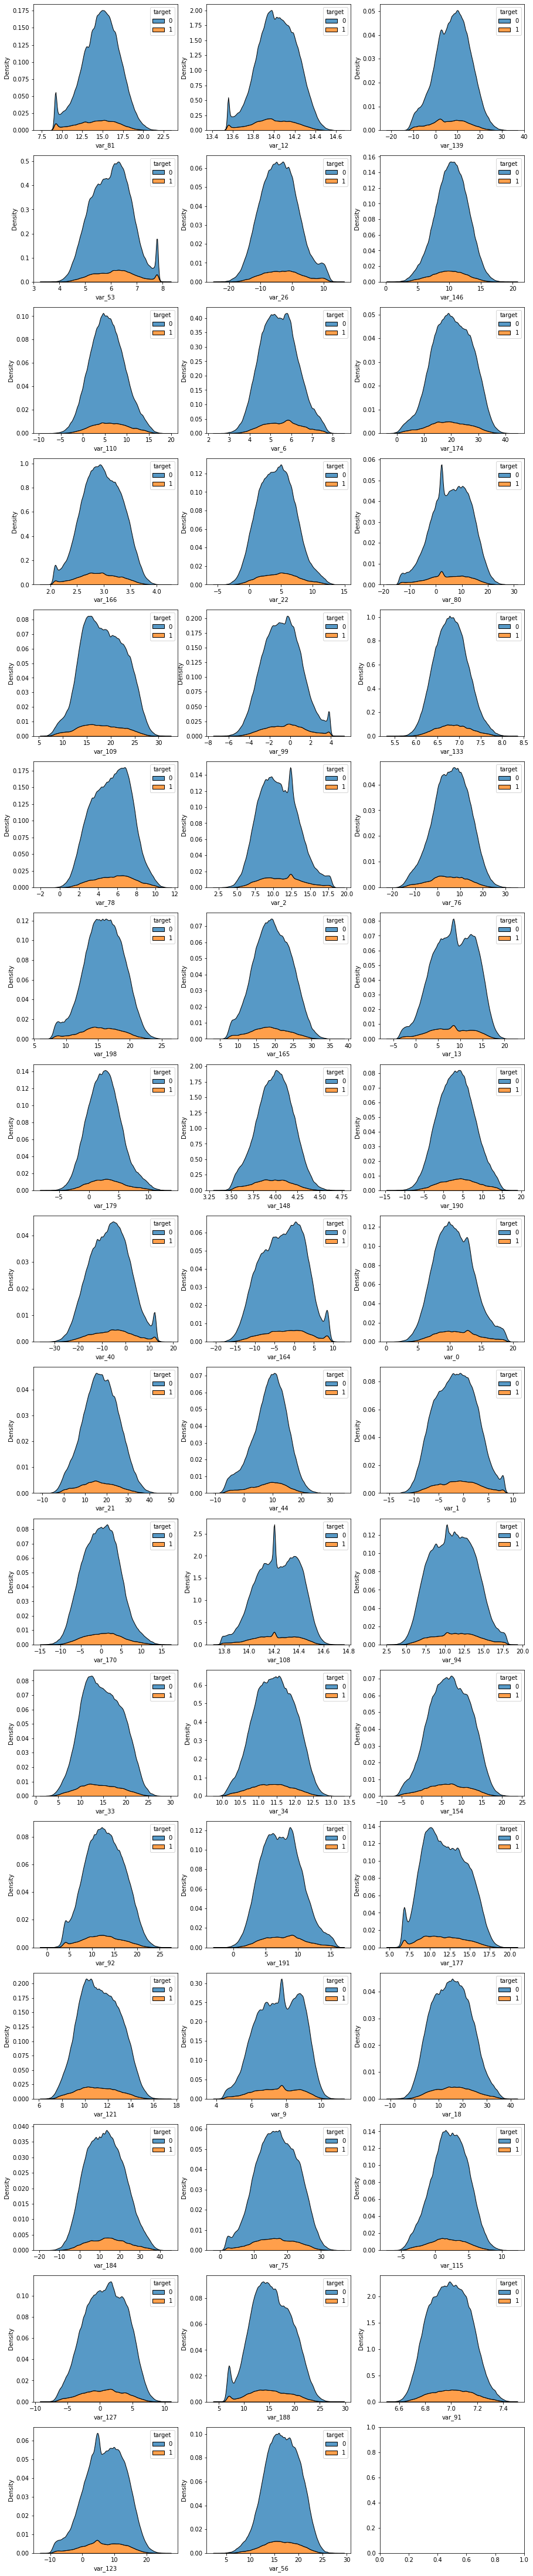

In [45]:
fig, axs = plt.subplots(ncols=3, nrows=17, figsize=(15, 80))
for k, var in enumerate(top_50_features):
    i = k // 3
    j = k % 3
    sns.kdeplot(ax=axs[i,j], data=df_train, x=var, hue="target", multiple="stack", bw_adjust=0.5)

#### Comments

We can observe that most of the features follow a distribution very close to the gaussian. Also, the value distribution of some features appear to be bimodal (e.g., `var_13`, `var_40`).

#### Let's take a look at the violin plots, once again comparing feature and target values

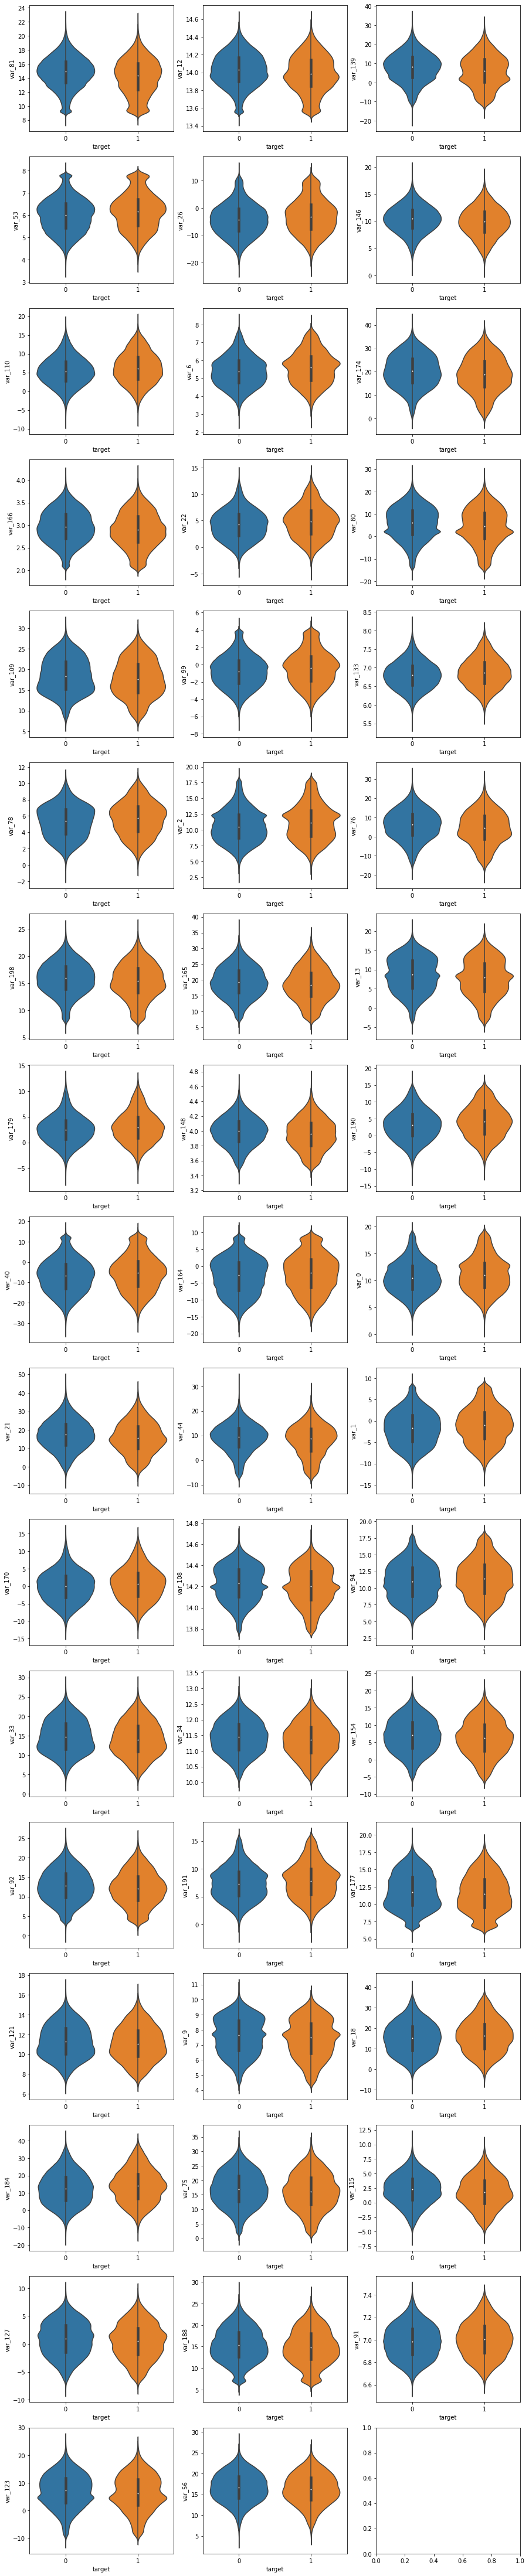

In [46]:
fig, axs = plt.subplots(ncols=3, nrows=17, figsize=(15, 80))
for k, var in enumerate(top_50_features):
    i = k // 3
    j = k % 3
    sns.violinplot(ax=axs[i,j], data=df_train, y=var, x="target")

#### Comments

Boxplots look more or less the same. For each feature, regardless of the target value (0 or 1), the distribution looks the same.

Also there we don't see any extreme outliers in any feature values. **Perhaps the outliers were previously removed to anonymize the data ?**

# 3. Feature engineering

Inspired by:

* https://www.kaggle.com/code/enesimek/for-beginners-santander-prediction-lgbm-model

## 3.0. Remove ID_code column

In [47]:
# Eliminando a variável ID, do dataset de teste
originalTestFeatures = df_test.drop('ID_code', axis = 1)

# Capturando a variável ID, do dataset de teste
testID = df_test.ID_code

## 3.1. Create features based on the statistical measures of each dataset column

Some features added:

a) maximum value of each row;

b) sum of each row;

c) standard deviation: as we have seen in the EDA part (`Section 2.8`), `target=0` likelihood distributions are more concentrated around their mean than `target=1`.

d) skewness: Skewness refers to a distortion or asymmetry that deviates from the symmetrical bell curve (normal distribution), in a set of data.

e) kurtosis: kurtosis is a measure of whether the data are heavy-tailed or light-tailed, relative to a normal distribution. Kurtosis identifies weather the tails of the distributions contains extreme values. There may be a chance that, if the behavior of customer is different, he will make a transaction.

In [48]:
%%time
idx = features = X_train.columns.values
for df in [X_test, X_train]:    
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 5.54 s, sys: 1.54 s, total: 7.08 s
Wall time: 7.09 s


In [49]:
X_train[X_train.columns[200:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,-9.955856,-2.364699,2.841156,-0.049779,0.924767,-0.132413,-0.072276,0.038841
1,3.080575,-2.466189,2.784951,0.015403,1.036771,-0.135547,-0.505121,0.134630
2,5.492622,-2.520798,2.779059,0.027463,1.135521,-0.007944,-0.558327,-0.042899
3,16.051836,-2.587605,2.651816,0.080259,0.969015,0.063049,-0.143383,0.038416
4,-0.723954,-2.705685,2.265932,-0.003620,0.977980,-0.166365,-0.252644,-0.054104


## 3.2. Create features from the rounding of the value of each existing feature (disabled)

Round each value to 1 or 2 digits after the period.

## 3.3. Create features from the frequency of each value, on each column (disabled)

Taken from Kernel: https://www.kaggle.com/code/cdeotte/200-magical-models-santander-0-920

# 4. Let's use the Pycaret library for model selection and hyperparameter tuning

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows.
PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and a few more.


## 4.1. A note on the train and test datasets (from Section 2.5.0)

To effectively apply the final prediction on unseen data (with Pycaret `predict_model()` function), in `Section 2.5.0` we took a sample of 25% of the records from the original dataset, to be used for predictions at the end. 

However, this should not be confused with a train-test-split for cross-validation purposes, as this particular split is performed to simulate a real-life scenario. Another way to think about this is that these 25% transactions are not available at the time of training of machine learning models.

In [50]:
# data constains 75% of the original Kaggle training dataset, data_unseen contains the other 25%
data = pd.concat([X_train, y_train], axis=1)
data_unseen = pd.concat([X_test, y_test], axis=1)

# print the revised shape
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (187329, 209)
Unseen Data For Predictions: (87533, 209)


## 4.2. Pre-process the dataset

Let's remove the `ID_code` column, which is not a useful feature.

In [51]:
data = data[[_ for _ in data.columns if _ != 'ID_code']]
data_unseen = data_unseen[[_ for _ in data_unseen.columns if _ != 'ID_code']]

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (187329, 209)
Unseen Data For Predictions: (87533, 209)


## 4.4. Setting up Pycaret Environment

### 4.4.1. Set up an experiment in PyCaret and get started with building classification models.



The setup function in PyCaret initializes the environment and creates the transformation pipeline for modeling and deployment. setup must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional can be used to customize the preprocessing pipeline.

When setup is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To handle this, PyCaret displays a prompt, asking for data types confirmation, once you execute the setup. You can press enter if all data types are correct or type quit to exit the setup.

Ensuring that the data types are correct is really important in PyCaret as it automatically performs multiple type-specific preprocessing tasks which are imperative for machine learning models.

In [52]:
feature_index_list = [_ for _ in range(X_train.shape[1])] # fs.get_support(indices=True)
###feature_index_list = fs2.get_support(indices=True)
feature_index_list = list(feature_index_list)

In [53]:
selected_features = X_train.columns[feature_index_list]
selected_features = [str(_) for _ in selected_features]

#### Train-test split for model traning and Pycaret setup

To perform model training, we will use a typical 75% x 25% to split the dataset into train and test data (`train_size=0.75` parameter).

### 4.2.2. Test Pycaret AutoML on the original dataset (including all features)

Let's perform a first model training with Pycaret, considering the original / full set of features, including the engineered ones. We will use the obtained results as a baseline for more advanced models and future tests with a subset of the original features.

In [58]:
# init setup
from pycaret.classification import *
###selected_features.append('target')
used_feature_list = selected_features + ['target']
used_feature_list = list(data.columns)
s = setup(data = data[used_feature_list], target = 'target', session_id=123,
                  n_jobs = -1, 
                  # use_gpu = True,
                  train_size = 0.75, 
                  # fix_imbalance=True, 
                  remove_perfect_collinearity = False,
                  #normalize = True, 
                  transformation = True, 
                  ###ignore_low_variance = True,
                  #feature_selection = True, 
                  #feature_selection_threshold = 0.8, 
                  #feature_selection_method = 'boruta',
                  #remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  #pca = True, pca_method = 'linear', pca_components = 10
         )

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
transformed_x = get_config('X_test')
final_features = [x for x in transformed_x.columns]
final_features

## 4.2.3. Create baseline models and compare them

### Create different models, perform stratified cross-validation and evaluate classification metrics

Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case). This function trains all models in the model library and scores them using stratified cross-validation for metric evaluation. The output prints a scoring grid that shows average Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC across the folds (10 by default) along with training times.

#### Comments

The scoring grid printed below highlights the highest performing metric for comparison purposes only. The grid by default is sorted using Accuracy (highest to lowest), but we will use the `sort='AUC'` parameter, since the binary `target` value is highly unbalanced and the area under de ROC curve is a better metric in these cases.

Also, to speed-up training times, we will reduce the number of CV fold to 5.

**Important**: As we will see in the results below, the metrics of interest (AUC, and very low Precision, Recall and F1) are really bad! This is because, even though the results are sorted according to the `AUC` metric, the model training was performed using the `Accuracy` metric, which is inadequate for our unbalanced case.

In [ ]:
top5 = compare_models(n_select = 3, sort='AUC', turbo=True, fold=5)

## 4.3. Defining auxiliary functions for model training purposes

Instead of using Pycaret AutoML, we will now define a couple of datasets, each one with a different type of normalization / standardization, and with a distinct subset of features.

### 4.3.1. Data transform function to apply different types of stanrdization and normalization

#### Applying different scales to train and test data

In [54]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, normalize

train_dict = dict()
test_dict = dict()
trainFeatures = train.drop(["ID_code", "target"], axis = 1)
testFeatures = test.drop(["ID_code", "target"], axis = 1)

# Criando um objeto da classe MinMaxScaler().
scaler = MinMaxScaler()
# Aplicando a escala nas Features e capturando o resultado obtido.
train_dict['MM'] = scaler.fit_transform(trainFeatures)
test_dict['MM'] = scaler.fit_transform(testFeatures)
# Criando um DataFrame com os resultados obtidos.
train_dict['MM'] = pd.DataFrame(data = train_dict['MM'], columns = trainFeatures.columns)
test_dict['MM'] = pd.DataFrame(data = test_dict['MM'], columns = testFeatures.columns)

# Criando um objeto da classe StandardScaler().
scaler = StandardScaler()
# Aplicando a escala nas Features e capturando o resultado obtido.
train_dict['SS'] = scaler.fit_transform(trainFeatures)
test_dict['SS'] = scaler.fit_transform(testFeatures)
# Criando um DataFrame com os resultados obtidos.
train_dict['SS'] = pd.DataFrame(data = train_dict['SS'], columns = trainFeatures.columns)
test_dict['SS'] = pd.DataFrame(data = test_dict['SS'], columns = testFeatures.columns)

# Criando um objeto da classe PowerTransformer().
scaler = PowerTransformer(method = 'yeo-johnson', standardize = False)
# Aplicando a escala nas Features e capturando o resultado obtido.
train_dict['ND'] = scaler.fit_transform(train_dict['SS'])
test_dict['ND'] = scaler.fit_transform(test_dict['SS'])
# Criando um DataFrame com os resultados obtidos.
train_dict['ND'] = pd.DataFrame(data = train_dict['ND'], columns = trainFeatures.columns)
test_dict['ND'] = pd.DataFrame(data = test_dict['ND'], columns = trainFeatures.columns)

# Normalizando cada feature para uma unidade uniforme (vetor unitário).
train_dict['NM'] = normalize(trainFeatures, axis = 1)
test_dict['NM'] = normalize(testFeatures, axis = 1)
# Criando um DataFrame com os resultados obtidos.
train_dict['NM'] = pd.DataFrame(data = train_dict['NM'], columns = trainFeatures.columns)
test_dict['NM'] = pd.DataFrame(data = test_dict['NM'], columns = trainFeatures.columns)

### 4.3.2. Create a dict with different subsets of features to use during model training

Previously, in `Section 2.6. Feature Selection`, we applied several methods to select the most important model features, and thus reduce the number of features to be used in model training. We will now create a `dict()` with these feature lists, to help us traing different models.

In [59]:
# Criando uma lista com todos os resultados gerados pelas técnicas de Feature Selection utilizadas anteriormente
featurelist_dict = dict()
df_dict_feature_score = dict()

# Load all feature list from each method used
df_dict_feature_score['information_gain'] = df_information_gain.rename(columns={"information_gain": "score"}) # information_gain (descending), up to  152 features
df_dict_feature_score['mean_abs_diff'] = df_mean_abs_diff.rename(columns={"mean_abs_diff": "score"}) # mean_abs_diff (descending)
df_dict_feature_score['disp_ratio'] = df_disp_ratio.rename(columns={"disp_ratio": "score"}) # disp_ratio (descending)
df_dict_feature_score['lr'] = lr_df.reset_index() # 'score'
df_dict_feature_score['anova'] = df_anova_scores.reset_index() # anova: 'score', up to 150 features
df_dict_feature_score['rf'] = rf_importance_df.rename(columns={"rf_importance": "score", "feature": "index"}) # rf_importance

num_feature_list = [150]  # 20, 40, 80, 120

for fs_method_name, fs_df in df_dict_feature_score.items():
    print(f'Process feature selection method: {fs_method_name}')
    fs_df.sort_values(by=['score'], ascending=False, inplace=True)
    for num_features in num_feature_list:
        featurelist = fs_df.head(num_features)['index'].to_list()
        featurelist_dict[fs_method_name + '_nf-' + str(num_features)] = featurelist
    # end for
# end for
featurelist_dict.keys()

Process feature selection method: information_gain
Process feature selection method: mean_abs_diff
Process feature selection method: disp_ratio
Process feature selection method: lr
Process feature selection method: anova
Process feature selection method: rf


dict_keys(['information_gain_nf-150', 'mean_abs_diff_nf-150', 'disp_ratio_nf-150', 'lr_nf-150', 'anova_nf-150', 'rf_nf-150'])

In [60]:
# the forward and backward methods have a different data structure regarning feature scores
df_dict_feature_score['bfs'] = df_backward_selection_stats #.rename(columns={"bfs_features": "score"}) # bfs_features, up to  100 features
df_dict_feature_score['sbs'] = df_forward_selection_stats #.rename(columns={"sbs_features": "score"}) # sbs_features, up to 196 features

# feature_idx 	cv_scores 	avg_score 	feature_names
#fs_method_name = 'bfs'
#for row in df_dict_feature_score['bfs'].itertuples():  # 1 .. 100
#    num_features = len(row.feature_names)
#    if num_features in [100]:  # 40, 80
#        featurelist = row.feature_names
#        featurelist_dict[fs_method_name + '_nf-' + str(num_features)] = list(featurelist)
#        print(num_features)
#        print(featurelist)
#    # end if
# end for
fs_method_name = 'sbs'
for row in df_dict_feature_score['sbs'].itertuples():  # 196 .. 200
    num_features = len(row.feature_names)
    if num_features in [196]:
        featurelist = row.feature_names
        featurelist_dict[fs_method_name + '_nf-' + str(num_features)] = list(featurelist)
        print(num_features)
        print(featurelist)
    # end if
# end for

# the full feature set - with or without stats features ; with or without quasiConstantFeatures
# Use the quasiConstantFeatures dict()
drop_cols = ['sum', 'min', 'max', 'mean', 'std', 'skew', 'kurt', 'med']
# featurelist_dict['full_plus_stats' + '_nf-' + str(len(X_train.columns))] = X_train.columns.to_list()
X_original = X_train.drop(columns=drop_cols)
featurelist_dict['original' + '_nf-' + str(len(X_original.columns))] = X_original.columns.to_list()
X_original2 = X_original.drop(columns=quasiConstantFeatures[0.1])
featurelist_dict['original_without_quasi_constant' + '_nf-' + str(len(X_original2.columns))] = X_original2.columns.to_list()

# the lasso_l1 and anova methods have generated a single list of features, with a specific number of variables
df_dict_feature_score['lasso_l1'] = df_lasso_l1 # sfm_features, 90 features
df_dict_feature_score['anova'] = df_anova # anova_features, 150 features
featurelist_dict['lasso_l1' + '_nf-' + str(90)] = X.columns[df_dict_feature_score['lasso_l1']['sfm_features']].to_list()
featurelist_dict['anova' + '_nf-' + str(150)] = X.columns[df_dict_feature_score['anova']['anova_features']].to_list()


196
('var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25', 'var_26', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90', 'var_91', 'var_92', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_98', 'var_99', 'var_100', 'var_101', 'va

In [61]:
# obtain the dataset on the selected features
# featurelist_dict['lasso_l1_nf-90']
featurelist_dict.keys()

dict_keys(['information_gain_nf-150', 'mean_abs_diff_nf-150', 'disp_ratio_nf-150', 'lr_nf-150', 'anova_nf-150', 'rf_nf-150', 'sbs_nf-196', 'original_nf-200', 'original_without_quasi_constant_nf-190', 'lasso_l1_nf-90'])

### 4.3.3. Boxplot function

In [62]:
# Definindo uma função para criar gráficos de Boxplot interativos com o plotly
def plotBoxplot(data, filename, title = 'Comparison of classification algorithms', yaxis = 'ROC', xaxis = 'Algorithm'):
    
    plt.figure(figsize=(15,10))
    ax = sns.boxplot(x="model", y="value", data=data)
    ax.set_title(title)
    fig = ax.get_figure()
    fig.savefig(f"{filename}.png")

### 4.3.4. Model training functions

Let's define functions to automate model training, testing each combination of normalization method, feature set, and removal of quasiConstantFeatures. 

We will test a couple of classifier algorithms using the `roc_auc` metric and `StratifiedKFold` with 5 folds:

* Logistic Regression (LR)
* Gaussian NB (NB)
* BalancedRandomForest (BRF)
* XGBoost
* LightGBM (LGBM)

In [69]:
# Definindo uma função, para treinar diferentes algoritmos, para prever a variável Target.
def classifiersTraining(features, tTarget, model_label, printMeans = True, scoring = 'roc_auc', 
                        make_plots=True, num_folds = 5):
    import time
    import os.path
    
    if kaggle:
        base_folder = '../input/santandercustomertransactionv1models'
    else:
        base_folder = '.'
    # end if
    results_filename = os.path.join(base_folder, f'test1_model_results-{model_label}.pkl')
    means_filename = os.path.join(base_folder, f'test1_model_means-{model_label}.pkl')
    if not kaggle:
        results_filename += '.gz'
        means_filename += '.gz'
    # end if
    if os.path.isfile(results_filename) and os.path.isfile(means_filename):
        print(f'Results filename {results_filename} already exists. Skipping training.')
        results = pd.read_pickle(results_filename)
        means = pd.read_pickle(means_filename)
    else:    
        # Definindo os valores, para o número de folds e para o seed.
        seed      = 100

        # Criando uma lista para armazenar os modelos que serão utilizados.
        models = []

        # Adicionando os modelos a lista.
        models.append(('LR'     , LogisticRegression(C=0.1, class_weight='balanced', n_jobs=-1)         ))
        # models.append(('LDA'    , LinearDiscriminantAnalysis() ))

        gnb = GaussianNB()
        gnb_param = {'var_smoothing': np.logspace(0,-15, num=20)}
        gnb_cv = GridSearchCV(gnb, gnb_param, cv=num_folds, scoring=scoring, verbose=0, n_jobs=-1, return_train_score=True)
        models.append(('NB'     , gnb_cv                 ))

        # models.append(('KNN'    , KNeighborsClassifier()       ))
        # models.append(('CART'   , DecisionTreeClassifier()     ))

        # rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced_subsample', n_jobs=-1, oob_score=True, max_samples=0.4, verbose=1)
        # models.append(('RF'     , rf_classifier     ))

        brf_classifier = BalancedRandomForestClassifier(max_depth=15, n_estimators=200, oob_score=True, replacement=True, verbose=1, max_samples=0.4, n_jobs=-1)
        models.append(('BRF'     , brf_classifier     ))

        # easy=EasyEnsembleClassifier(n_estimators=50, sampling_strategy='majority', random_state=42, replacement=True, verbose=1, n_jobs=-1)
        # models.append(('EEC'     , easy     ))

        xgb_class = XGBClassifier(max_depth=4, n_estimators=600, eta=0.1, booster='gbtree', subsample=0.4, verbosity=1, scale_pos_weight=8,
                      colsample_bytree=0.2, tree_method='gpu_hist', eval_metric='aucpr', use_label_encoder=False)
        models.append(('XGBoost', xgb_class          ))

        lgbm_param = {
             'num_leaves': 18,
             'max_bin': 63,
             'min_data_in_leaf': 5,
             'learning_rate': 0.010614430970330217,
             'min_sum_hessian_in_leaf': 0.0093586657313989123,
             'feature_fraction': 0.056701788569420042,
              # 'lambda_l1': 0.060222413158420585,
              # 'lambda_l2': 4.6580550589317573,
             'min_gain_to_split': 0.29588543202055562,
             'max_depth': 49,
             'save_binary': True,
             'seed': 1337,
             'feature_fraction_seed': 1337,
             'bagging_seed': 1337,
             'drop_seed': 1337,
             'data_random_seed': 1337,
             'objective': 'binary',
             'boosting_type': 'gbdt',
             'verbose': 1,
             'metric': 'auc',
             'is_unbalance': True,
             'boost_from_average': False
        }
        lgbm_class = lightgbm.LGBMClassifier(**lgbm_param)
        models.append(('LGBM',    lgbm_class    ))

        # Criando Listas, para armazenar os resultados e os nomes, de cada um dos algoritmos testados.
        results = []
        names   = []

        # Criando um Dataframe, para armazenar a média e o desvio-padrão, de cada um dos algoritmos testados.
        means   = pd.DataFrame(columns = ['mean', 'std'])

        # Avaliando cada um dos modelos da lista de modelos.
        for name, model in models:
            start = time.time()

            # IMPORTANTE! Instanciando um objeto da StratifiedKFold para criar os folds, pois ha desbalanceamento do target
            kfold = StratifiedKFold(n_splits = num_folds , shuffle = True, random_state = seed)

            # Treinando o modelo com Cross Validation.
            cv_results = cross_val_score(model, features, tTarget, cv = kfold, scoring = scoring)

            # Adicionando os resultados gerados a lista de resultados.
            results.append(cv_results)

            # Adicionando o nome do modelo avaliado a lista de nomes.
            names.append(name)

            stop = time.time()
            time_spent = stop - start
            print(f"{name} model training time: {time_spent}s")

            # Adicionando a média e o desvio-padrão dos resultados gerados, pelo modelo analisado ao Dataframe de médias.
            means = means.append(
                pd.DataFrame (
                    data    = [[cv_results.mean(), cv_results.std(), time_spent]], 
                    columns = ['mean', 'std', 'time_spent_s'], 
                    index   = [name]
                )
            )

            # Imprime uma mensagem, contendo os resultados obtidos, ao fim do treinamento de cada um dos modelos.
            if printMeans:
                # Cria a mensagem a ser impressa.
                msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())

                # Imprime a mensagem.
                print(msg)
            # end if
        # end for

        # Cria um DataFrame com os resultados obtidos por cada um dos modelos avaliados.
        results = pd.DataFrame(np.transpose(results), columns = names)

        # Salva os resultados do treinamento em disco
        results.to_pickle(results_filename)
        print(f'Saved file {results_filename}.')
        display(results)

        means.to_pickle(means_filename)
        print(means_filename)
        display(means)
    # end if
    
    if make_plots:
        # Plotando os scores da metrica escolhida dos classificadores treinados, na forma de boxplots
        data_to_plot = pd.melt(results.reset_index(), id_vars=['index'], var_name='model', value_vars=results.columns.to_list())
        plotBoxplot(data = data_to_plot, filename = f'boxplot_{model_label}')
    # end if
    # Retorna o DataFrame, com os resultados e com as médias geradas.
    return (results, means)


In [64]:
# Definindo uma função para realizar a plotagem de Confusions Matrix
def plotConfusionMatrix(data, labels, figsize = (6, 6), fontScale = 1.2, title = 'Confusion Matrix', 
                        xlabel = 'Actual', ylabel = 'Predicted'):

    # Definindo a área de plotagem e suas dimensões.
    _, ax = plt.subplots(figsize = figsize)

    # Definindo o tamanho da fonte utilizada no gráfico.
    sns.set(font_scale = fontScale)

    # Criando Heatmap para representar a Confusion Matrix.
    ax = sns.heatmap (
        data       = data,
        annot      = True,
        cmap       = 'Blues',
        linewidths = 5,
        cbar       = False,
        #fmt        = 'd'
    ) 

    # Definindo as labels e o título do gráfico. 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel) 
    ax.set_title(title)

    # Definindo as ticklabels do gráfico.
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels);

In [65]:
# Definindo uma função para criar uma Confusion Matrix
def confusionMatrix(yTrue, yPred, labelPositive = 'Yes', labelNegative = 'No', classError = True):

    # Convertendo arrays para o tipo de dado categórico.
    labels = [labelNegative, labelPositive]
    yTrue = pd.Categorical(values = yTrue, categories = labels)
    yPred = pd.Categorical(values = yPred, categories = labels)

    # Transformando arrays em Séries Temporais.
    yPred = pd.Series(data = yPred, name = 'Predicted')
    yTrue = pd.Series(data = yTrue, name = 'Actual')

    # Criando a Confusion Matrix.
    cm = pd.crosstab(index = yPred, columns = yTrue, dropna = False)

    # Calculando os erros, das classes da Confusion Matrix.
    if classError:
        # Capturando cada um dos valores da Confusion Matrix.
        truePositve, falsePositive, falseNegative, trueNegative = np.array(cm).ravel()

        # Criando um DataFrame, contendo os erros das classes.
        ce = pd.DataFrame (
            data = [
                falsePositive / (truePositve + falsePositive),
                1 - trueNegative / (trueNegative + falseNegative)
            ],
            columns = ['classError'],
            index   = labels
        )

        # Inserindo no DataFrame, as colunas da Confusion Matrix.
        for c in range(cm.shape[1] - 1, -1, -1):
            # Inserindo as colunas no DataFrame.
            ce.insert(loc = 0, column = labels[c], value = cm[labels[c]])

        # Atribuindo índices e colunas ao DataFrame.
        ce.index   = pd.Series(ce.index, name = 'Predicted')
        ce.columns = pd.Series(ce.columns, name = 'Actual')

        # Retornando a Confusion Matrix, com o erro das classes.
        return ce

    # Retornando Confusion Matrix
    return cm

In [66]:
# Definindo uma função, para realizar o cálculo do Intervalo de Confiança, da acurácia e do erro de modelos 
# preditivos de classificação.
def CI(score, nElements,  ci = .95):

    # Define o Z-score, a ser utilizado para o Intervalo de Confiança selecionado.
    z = {
        .90  : 1.645,      # Para Intervalos com 90% de Confiança.
        .95  : 1.96,       # Para Intervalos com 95% de Confiança.
        .98  : 2.326,      # Para Intervalos com 98% de Confiança.
        .99  : 2.576,      # Para Intervalos com 99% de Confiança.
        .995 : 2.807,      # Para Intervalos com 99.5% de Confiança.
        .999 : 3.291       # Para Intervalos com 99.9% de Confiança.
    }

    # Calculando o range de variação do Intervalo.
    interval = z.get(ci) * np.sqrt( (score * (1 - score)) / nElements)

    # Retornando o Intervalo de Confiança obtido.
    return score - interval, score + interval

In [67]:
# Definindo uma função para calcular as métricas baseadas na Confusion Matrix
def getClassificationMetrics(yTrue, predProb, labelPositive = 'Yes', labelNegative = 'No'):

    # Binarizando os scores obtidos nas previsões.
    yPred = [labelPositive if v >= 0.5 else labelNegative for v in predProb]
    
    # Convertendo arrays para o tipo categórico.
    labels = [labelPositive, labelNegative]

    yTrue = pd.Categorical(values = yTrue, categories = labels)
    yPred = pd.Categorical(values = yPred, categories = labels)

    # Convertendo arrays para o tipo numérico. 
    yNTrue = [1 if v == labelPositive else 0 for v in yTrue]
    yNPred = [1 if v == labelPositive else 0 for v in yPred]

    # Transformando arrays em Séries Temporais.
    yPred = pd.Series(data = yPred, name = 'Predicted')
    yTrue = pd.Series(data = yTrue, name = 'Actual')

    # Criando a Confusion Matrix.
    cm = confusionMatrix(yTrue, yPred, labelPositive = labelPositive, labelNegative = labelNegative, classError = False)

    # Capturando cada um dos valores da Confusion Matrix.
    truePositve, falsePositive, falseNegative, trueNegative = np.array(cm).ravel()

    # Calculando as métricas.
    accuracy     = accuracy_score(yTrue, yPred)
    accuracyCI   = CI(accuracy_score(yTrue, yPred), len(yTrue))
    kappa        = cohen_kappa_score(yTrue, yPred)
    sensitivity  = recall_score(yNTrue, yNPred)
    specificity  = trueNegative /(trueNegative + falsePositive)
    prevalence   = (truePositve + falseNegative) / len(yTrue)
    ppv          = (sensitivity * prevalence) /((sensitivity * prevalence) + ((1 - specificity) * (1 - prevalence)))
    npv          = (specificity * (1 - prevalence)) / (((1 - sensitivity) * prevalence) + ((specificity) * (1 - prevalence)))
    precision    = precision_score(yNTrue, yNPred)
    avgPrecision = average_precision_score(yNTrue, yNPred)
    dRate        = truePositve / len(yTrue)
    dPrevalence  = (truePositve + falsePositive) / len(yTrue)
    f1           = f1_score(yNTrue, yNPred)
    rocAuc       = roc_auc_score(yNTrue, predProb)
    Aucpr        = average_precision_score(yNTrue, predProb)
    error        = 1 - accuracy_score(yTrue, yPred)
    errorCI      = CI(error, len(yTrue))
    bAccuracy    = balanced_accuracy_score(yTrue, yPred)

    # Criando um DataFrame, com o resultado das métricas calculadas.
    metrics = pd.DataFrame([{
        'Accuracy'            : accuracy,     # Determina a precisão geral prevista do modelo.
        '95% CI for Accuracy' : accuracyCI,   # Determina um intervalo de confiança de 95% para a acurácia.
        'Kappa'               : kappa,        # Determina o coeficiente de Kappa.
        'Recall (Sensitivity)': sensitivity,  # Determina a proporção de registros positivos que foram classificados 
                                              # pelo algoritmo como positivos.
        'Specificity'         : specificity,  # Determina a proporção de registros negativos que foram classificados 
                                              # pelo algoritmo como negativos.
        'Pos Pred Value'      : ppv,          # Determina a porcentagem de positivos previstos que são realmente positivos.
        'Neg Pred Value'      : npv,          # Determina a porcentagem de negativos previstos que são realmente negativos.
        'Precision'           : precision,    # Determina a proporção de classificações positivas, que realmente são 
                                              # positivas.
        'Avarage Precision'   : avgPrecision, # Determina a precisão como a média ponderada de precisões alcançadas em 
                                              # cada limite.
        'Prevalence'          : prevalence,   # Determina a frequência com que a classe positiva realmente ocorre em nossa 
                                              # amostra.
        'Detection Rate'      : dRate,        # Determina a proporção de classificações positivas feitas corretamente em 
                                              # relação a todas as previsões feitas.
        'Detection Prevalence': dPrevalence,  # Determina o número de previsões positivas como uma proporção de todas
                                              # as previsões.
        'F1'                  : f1,           # Determina a média Harmônica entre a precision e o recall do modelo.
        'ROC AUC'             : rocAuc,       # Determina a medida de separabilidade ROC. Ela indica o quanto o modelo 
                                              # é capaz de distinguir as classes.  
        'AUC PR'              : Aucpr,        # Determina a medida AUC PR (Precision-Recall). Pode ser utilizada como alternativa
                                              # a medida ROC, no caso de desbalanceamento das classes.
        'Error'               : error,        # Determina o erro do modelo em relação a sua acurácia.
        '95% CI for Error'    : errorCI,      # Determina um intervalo de confiança de 95% para o erro.
        'Balanced Accuracy'   : bAccuracy,    # Determina a acurácia do modelo balanceada pelos tamanhos das classes.
        'Positive Class'      : labelPositive # Define qual classe é a classe positiva.
    }], index = ['Metrics']).transpose()

    # Retornando o DataFrame, com as métricas obtidas.
    return metrics

# Definindo uma função para salvar um modelo preditivo já treinado
def saveModel(name, model, fold = './', ext = '.sav'):
    # Definindo o diretório e o nome do arquivo que será utilizado para salvar o modelo
    dir = fold + name + ext

    # Salvando o modelo especificado
    pickle.dump(model, open(dir, 'wb'))

    # Imprimindo mensagem de sucesso.
    print("Modelo salvo!")

# Definindo uma função para carregar um modelo preditivo já treinado
def loadModel(name, fold = './', ext = '.sav'):
    # Definindo o diretório e o nome do arquivo que será utilizado para carregar o modelo
    dir = fold + name + ext

    # Imprimindo mensagem de sucesso
    print("Modelo carregado!")

    # Carregando o modelo especificado
    return pickle.load(open(dir, 'rb'))

## 4.4. Model training loop

Let's now train several models, with the different combinations of normalization / standardization and feature subsets.

We will also generate boxplots depicting the score distribution of each model validation.


Training for information_gain_nf-150 x MM...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-information_gain_nf-150-MM.pkl already exists. Skipping training.
Training for information_gain_nf-150 x SS...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-information_gain_nf-150-SS.pkl already exists. Skipping training.
Training for information_gain_nf-150 x ND...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-information_gain_nf-150-ND.pkl already exists. Skipping training.
Training for information_gain_nf-150 x NM...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-information_gain_nf-150-NM.pkl already exists. Skipping training.
Training for mean_abs_diff_nf-150 x MM...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-mean_abs_diff_nf-150-MM.pkl already exists. Skipping training.
Training for mean_abs_diff_nf-150 x 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


Training for rf_nf-150 x SS...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-rf_nf-150-SS.pkl already exists. Skipping training.
Training for rf_nf-150 x ND...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-rf_nf-150-ND.pkl already exists. Skipping training.
Training for rf_nf-150 x NM...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-rf_nf-150-NM.pkl already exists. Skipping training.
Training for sbs_nf-196 x MM...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-sbs_nf-196-MM.pkl already exists. Skipping training.
Training for sbs_nf-196 x SS...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-sbs_nf-196-SS.pkl already exists. Skipping training.
Training for sbs_nf-196 x ND...
Results filename ../input/santandercustomertransactionv1models/test1_model_results-sbs_nf-196-ND.pkl already exists. Skipping training

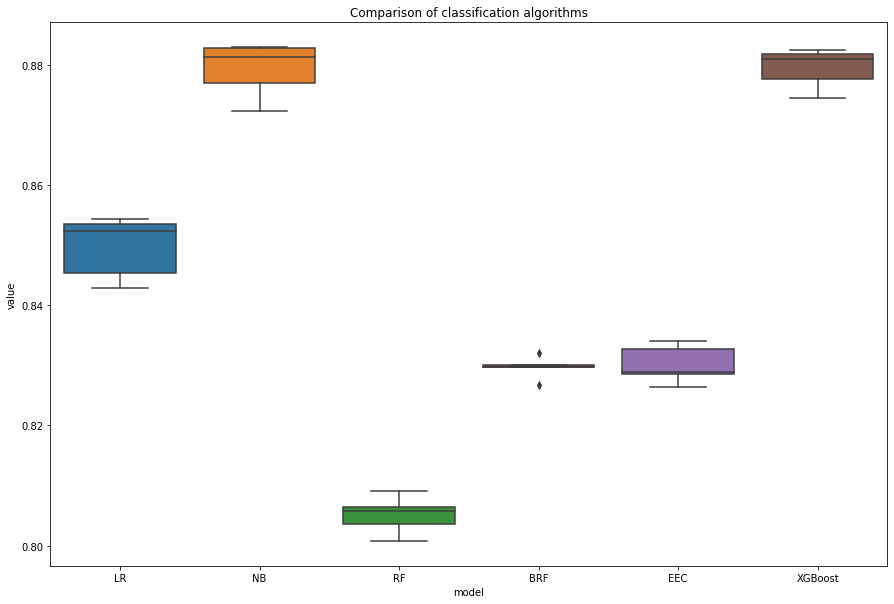

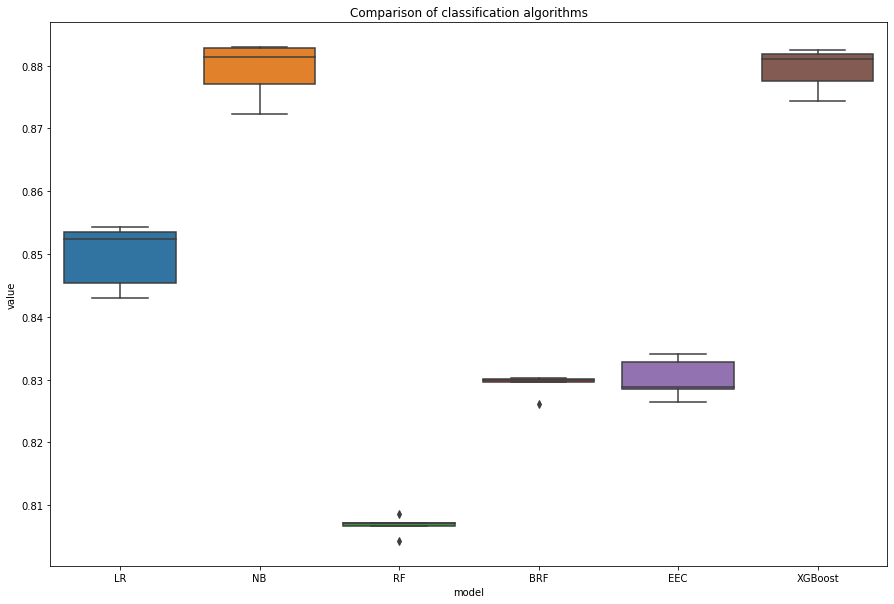

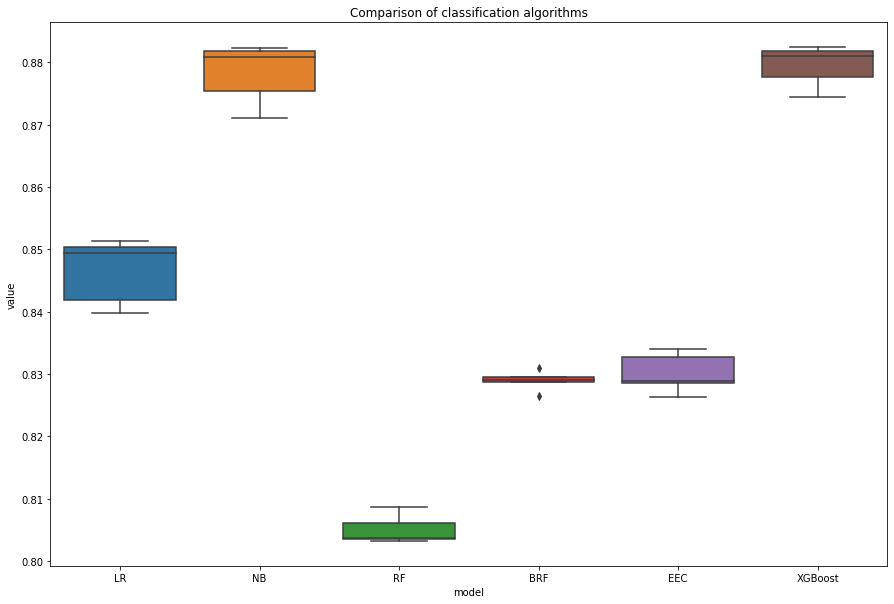

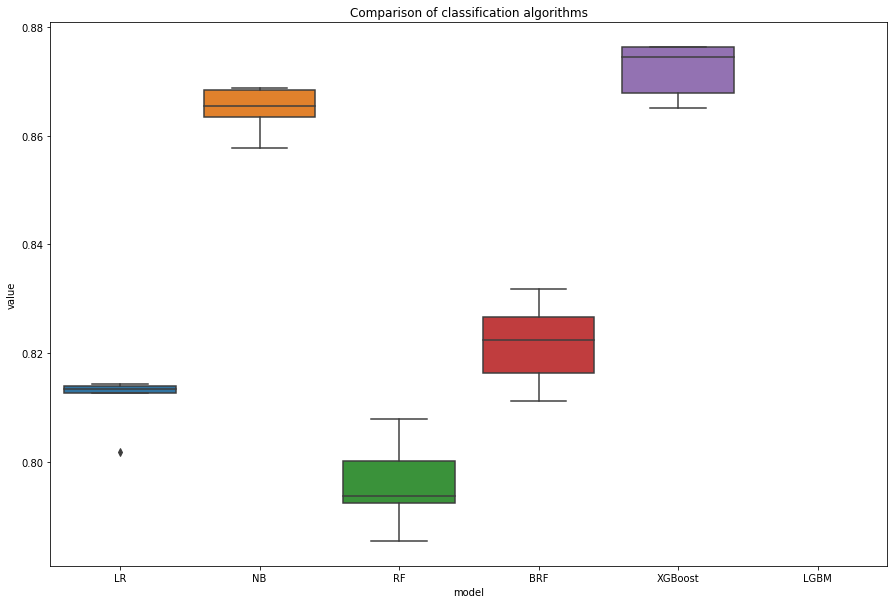

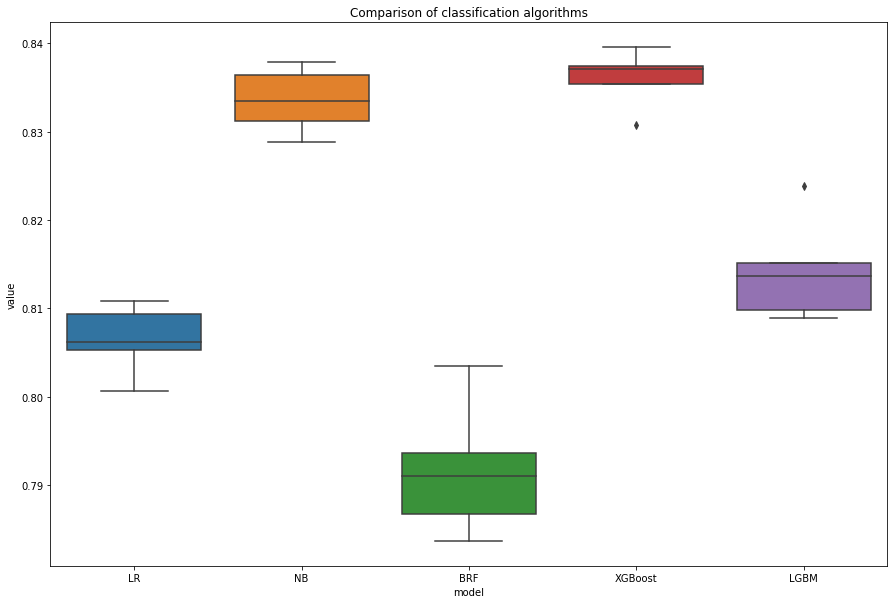

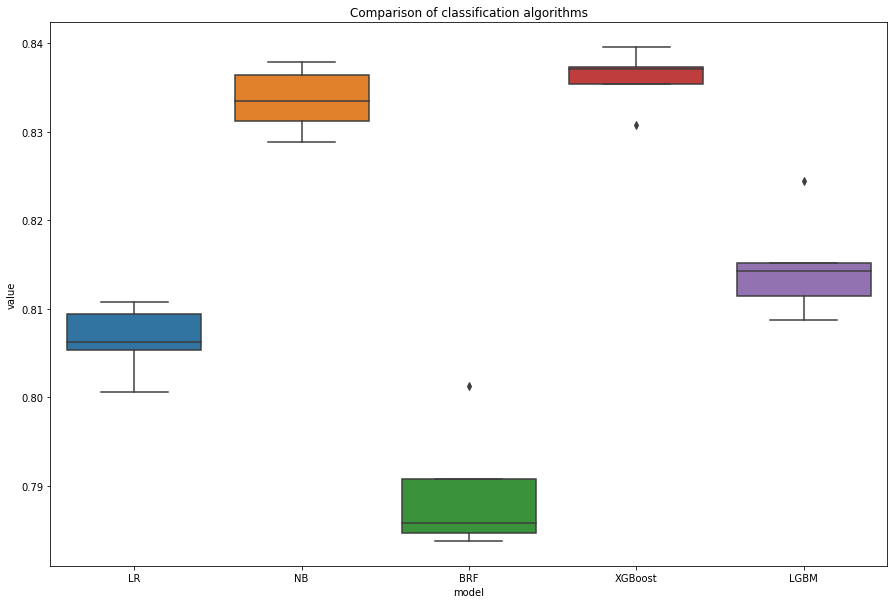

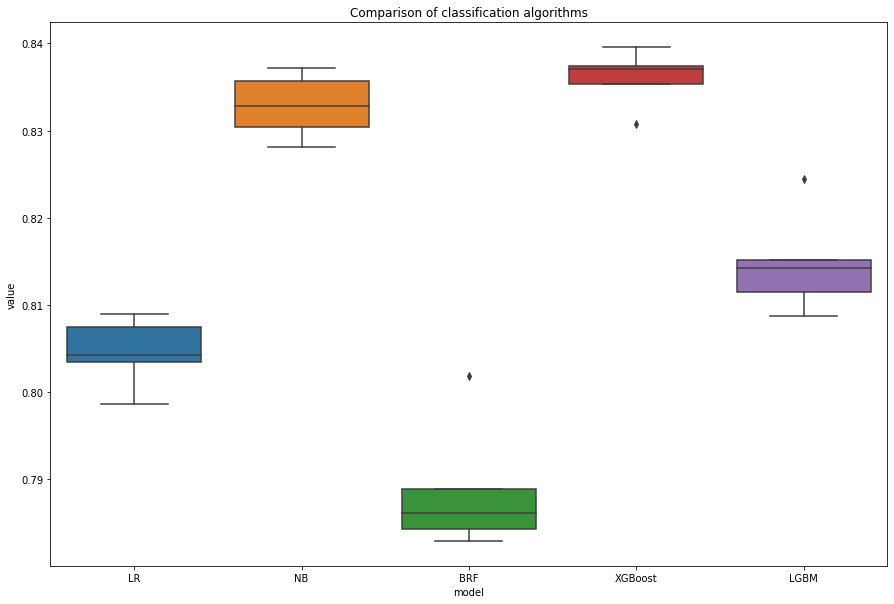

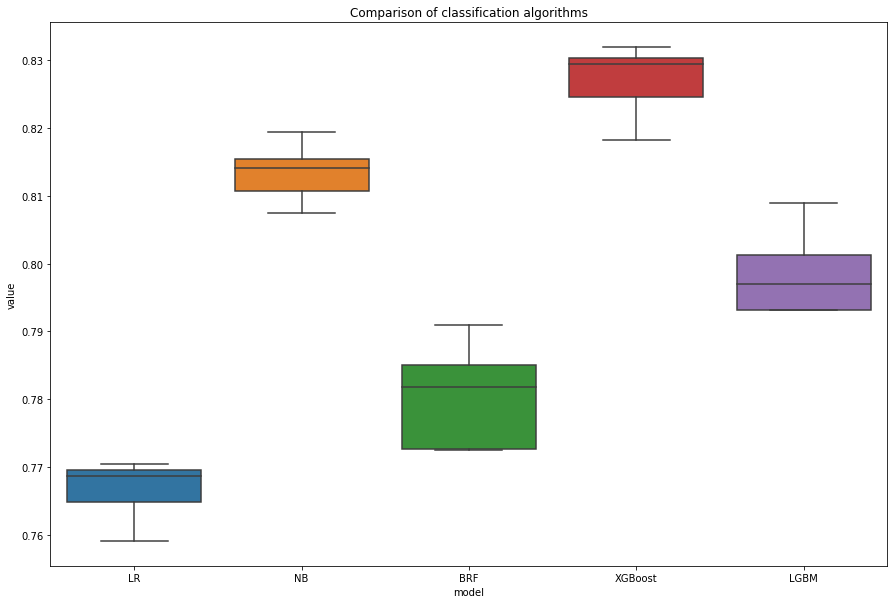

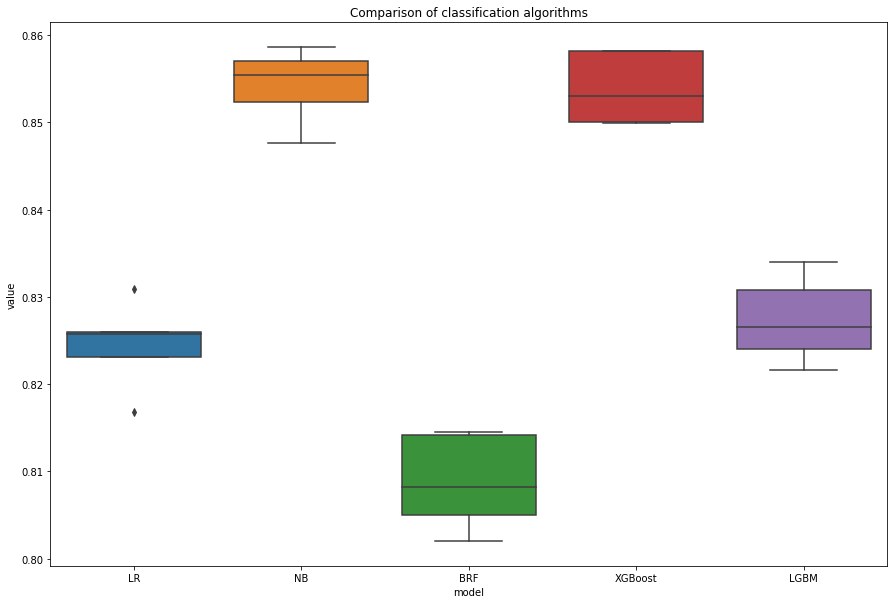

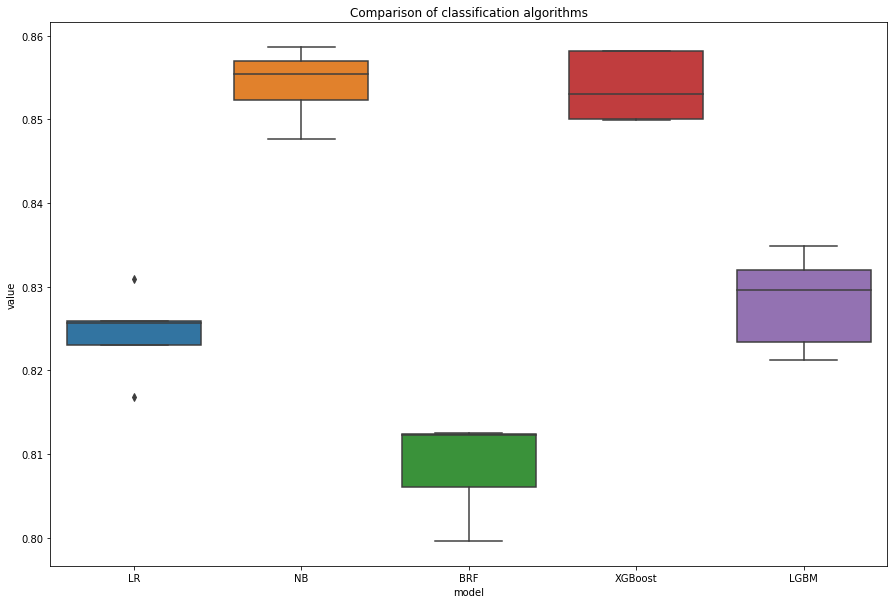

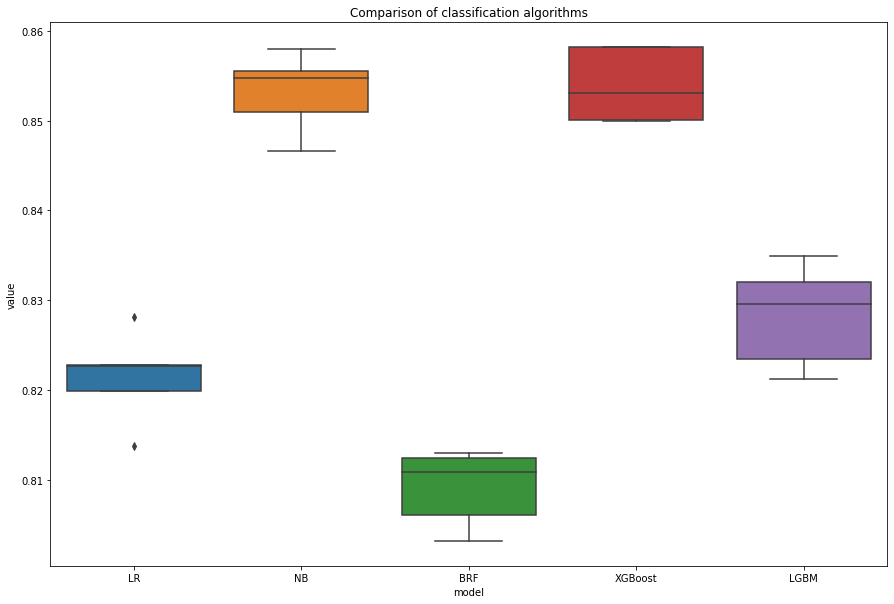

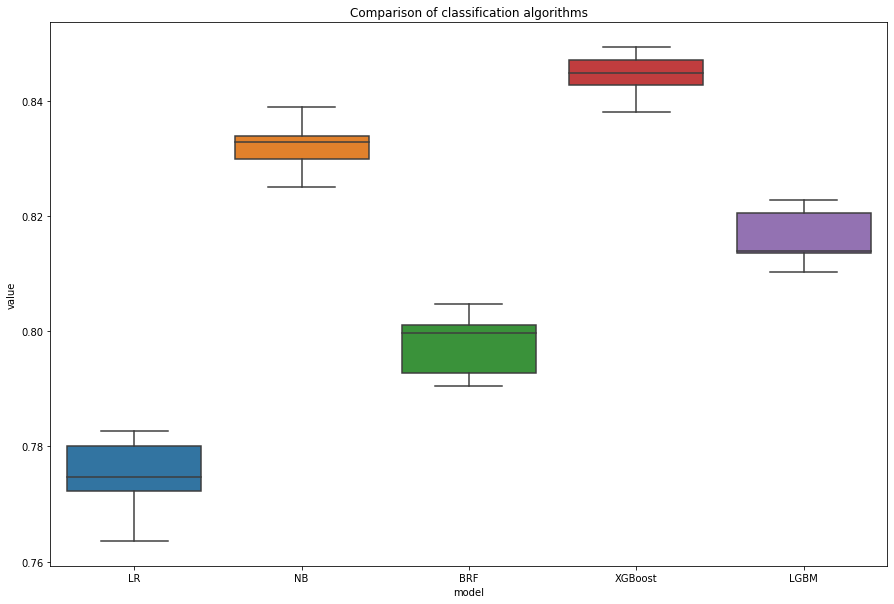

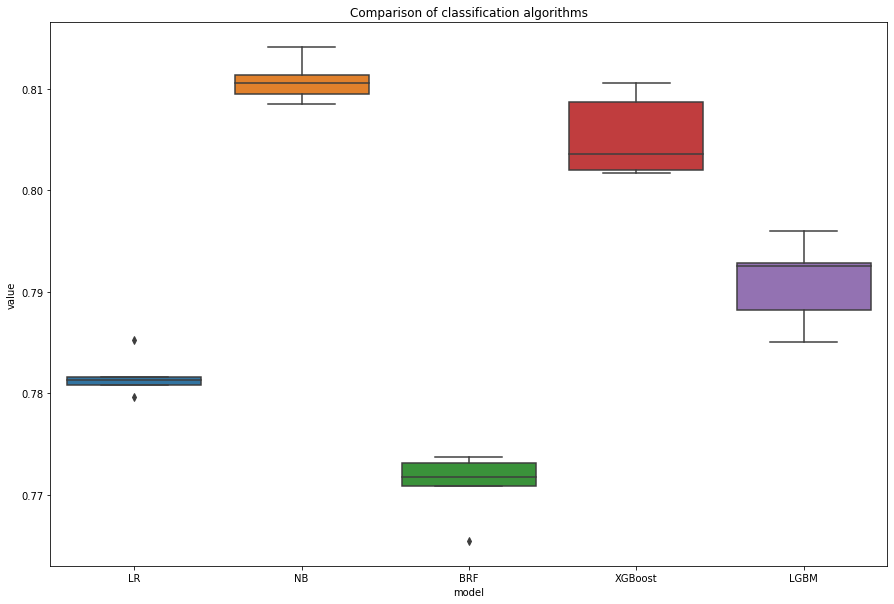

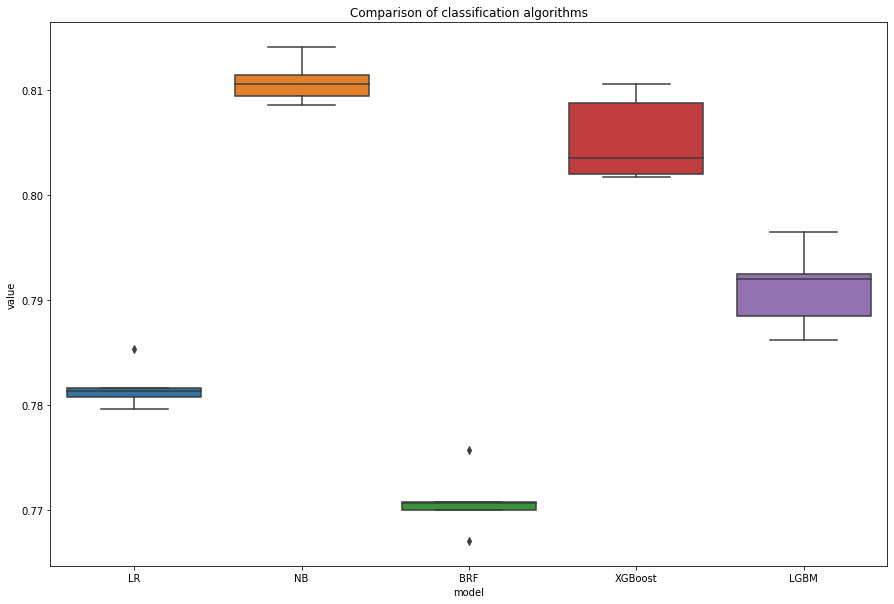

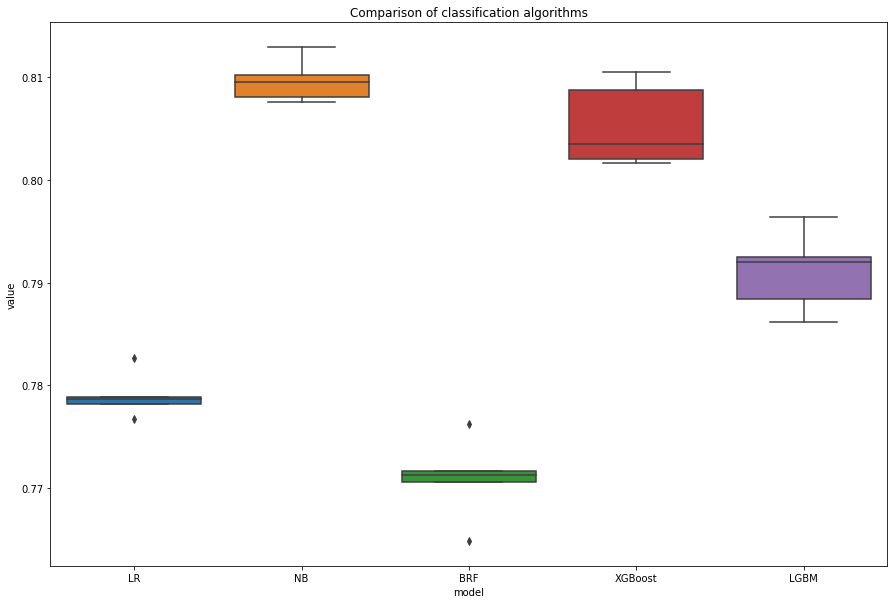

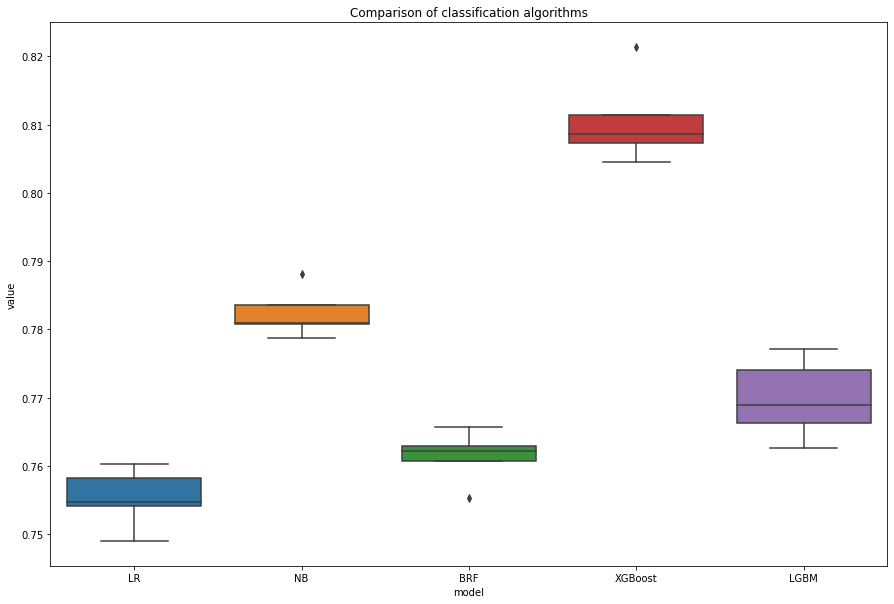

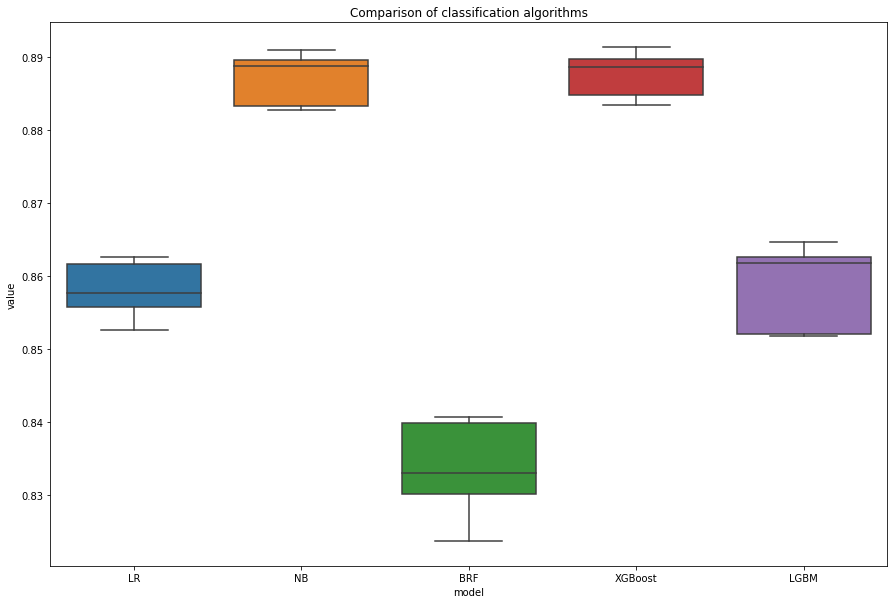

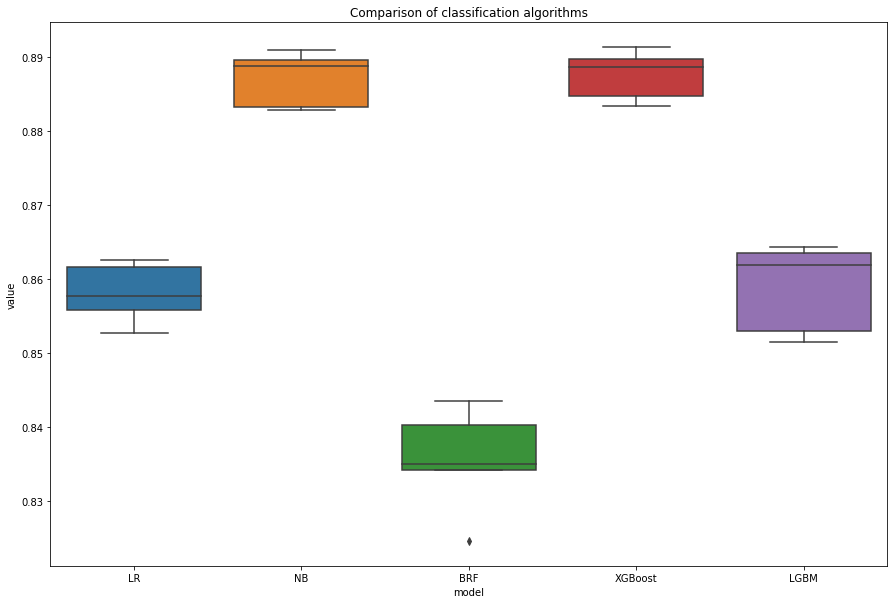

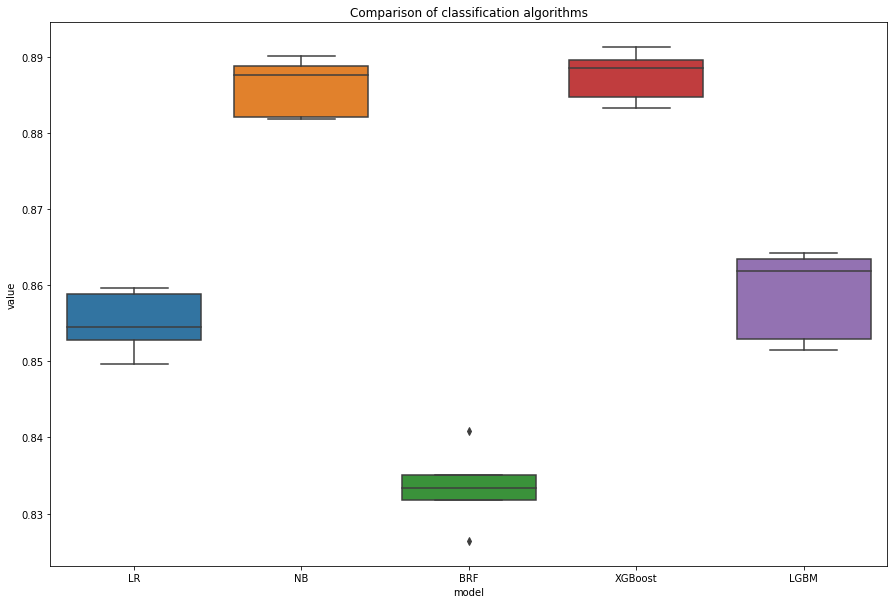

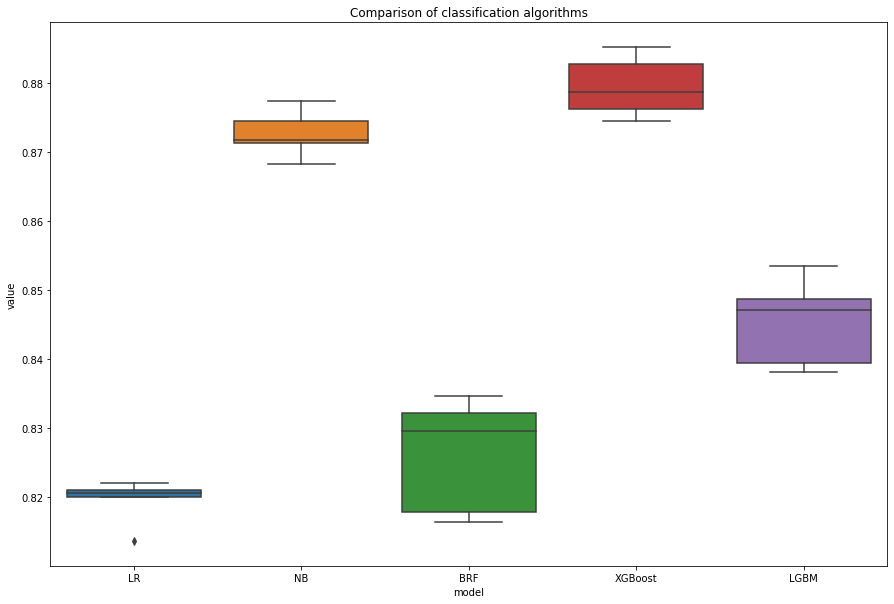

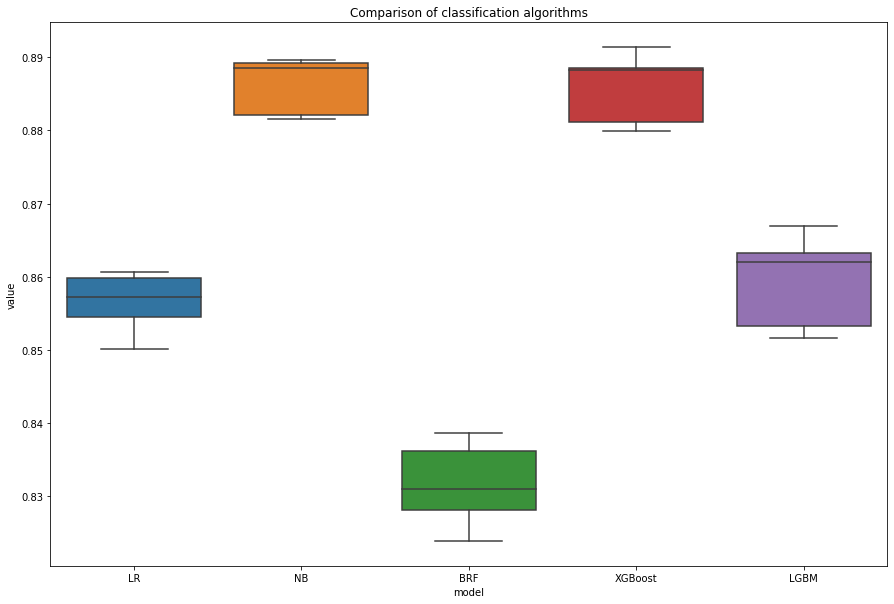

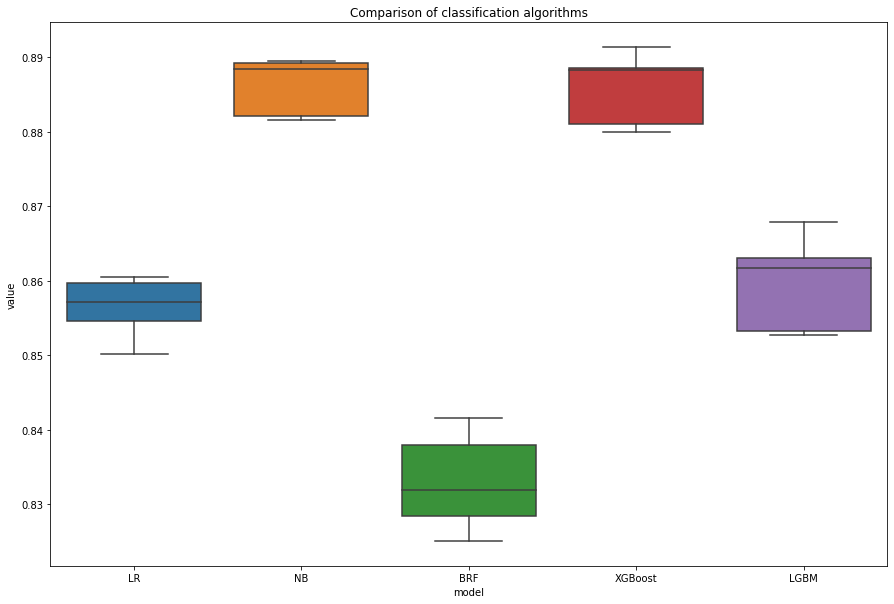

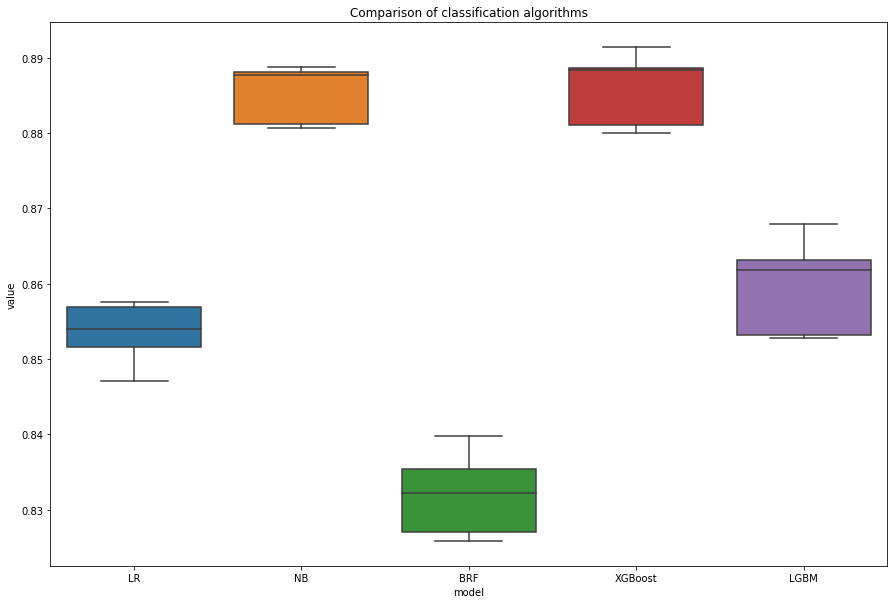

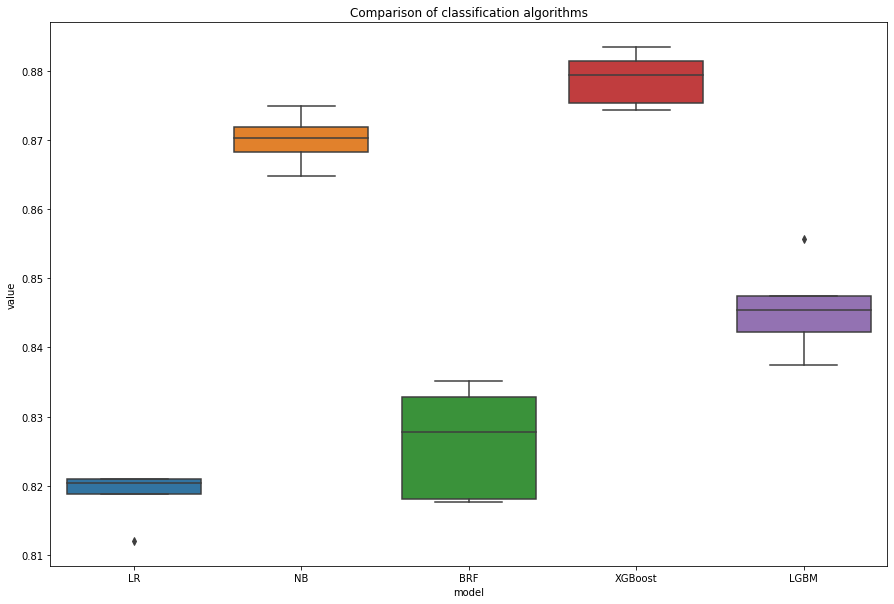

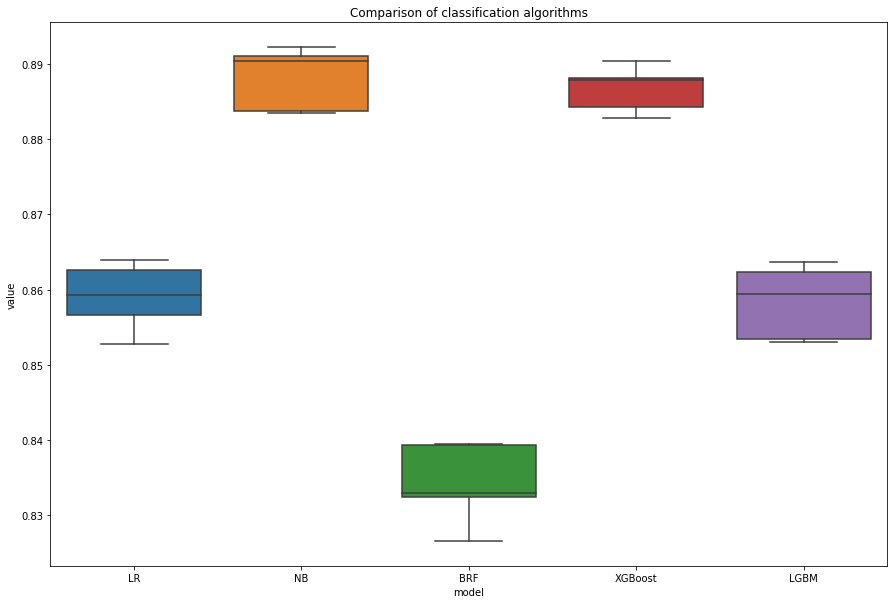

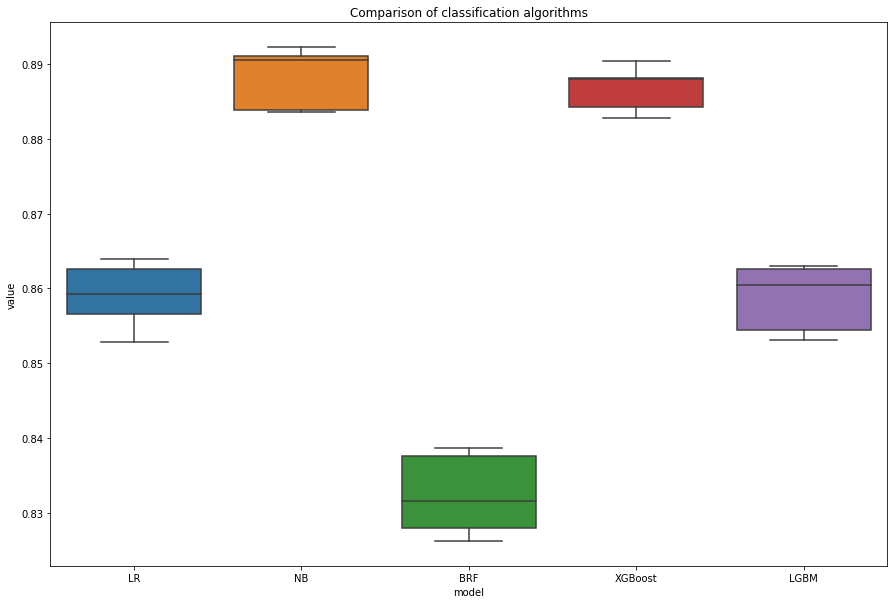

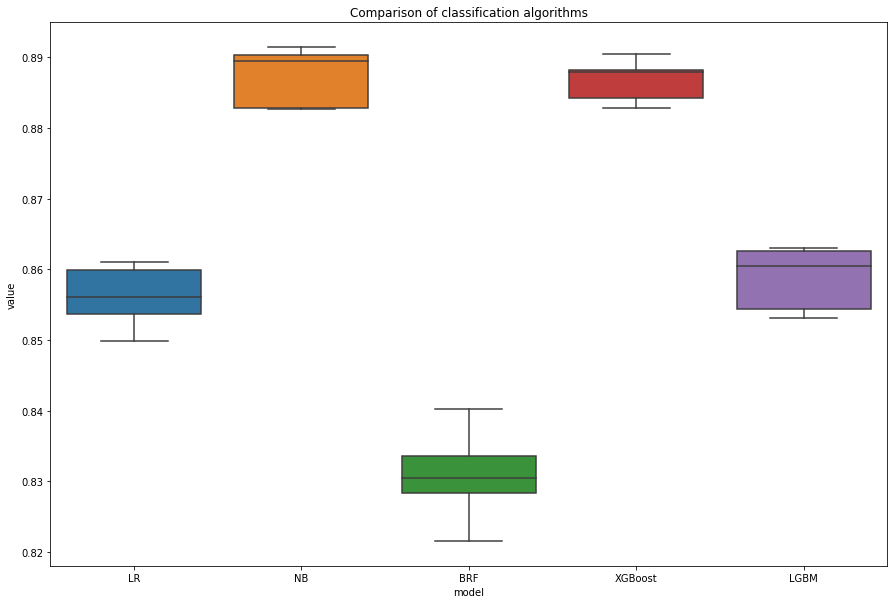

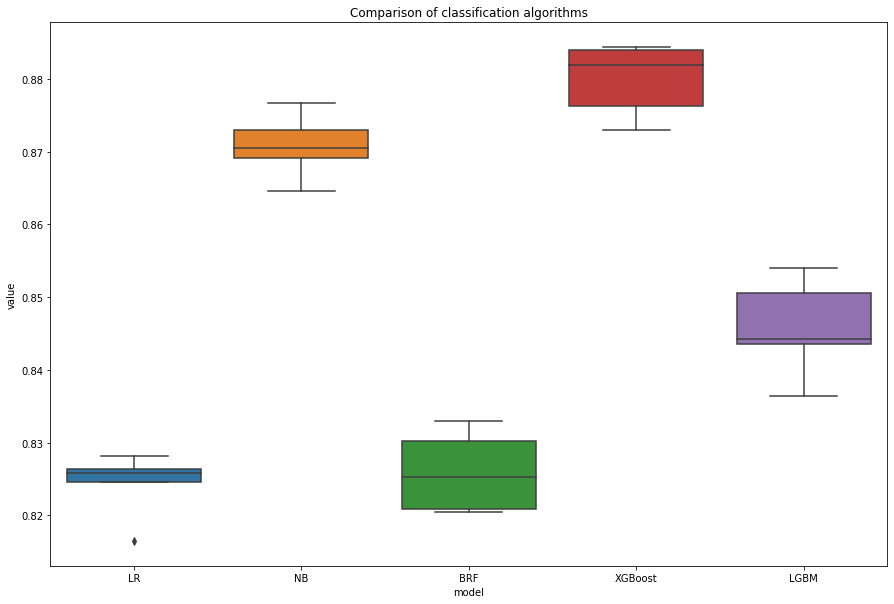

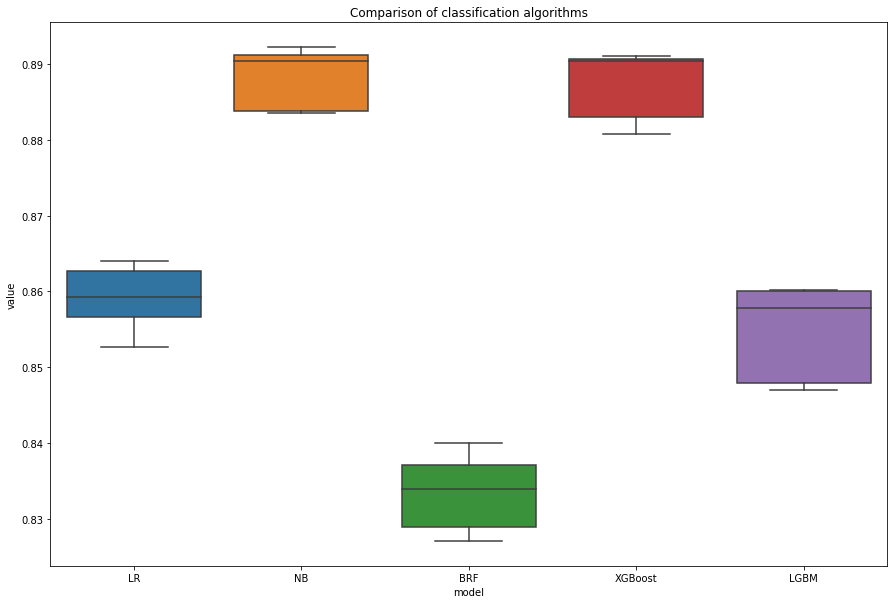

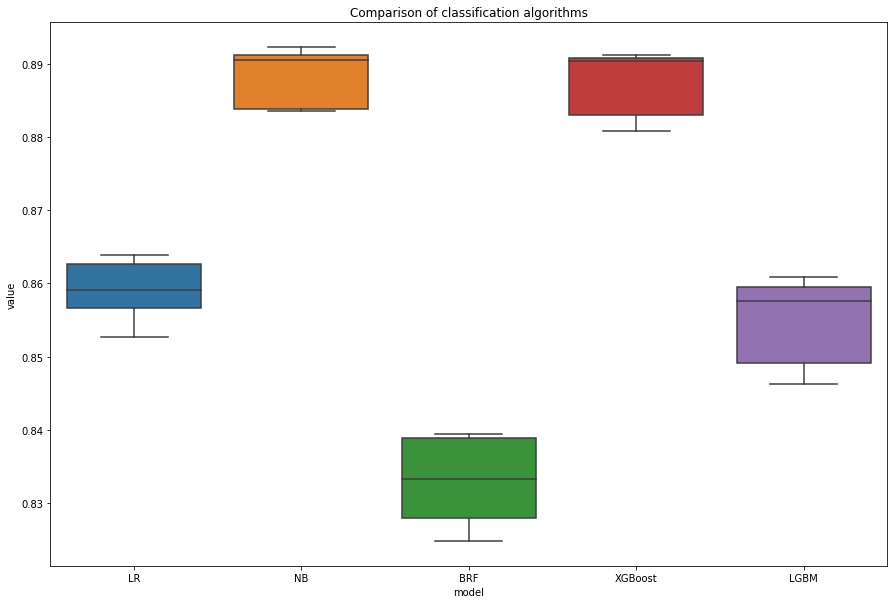

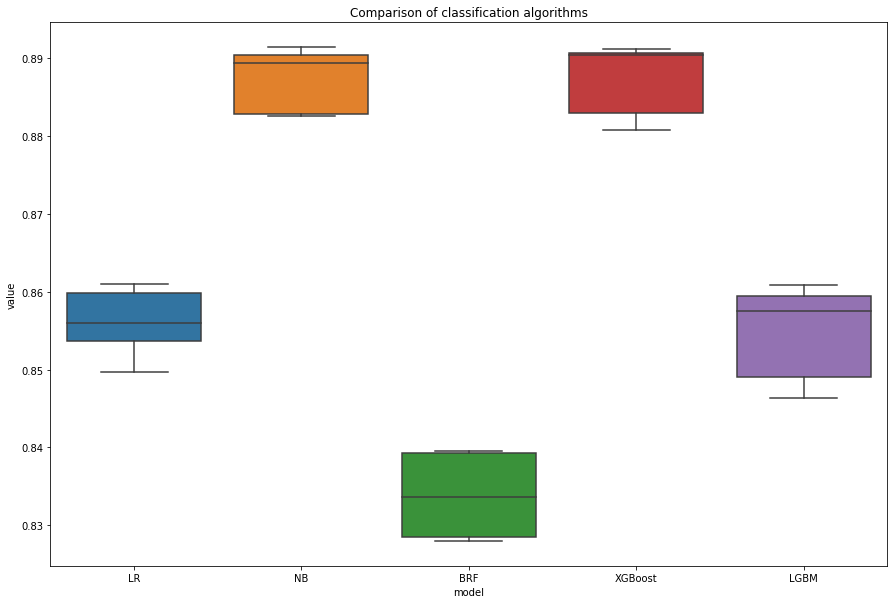

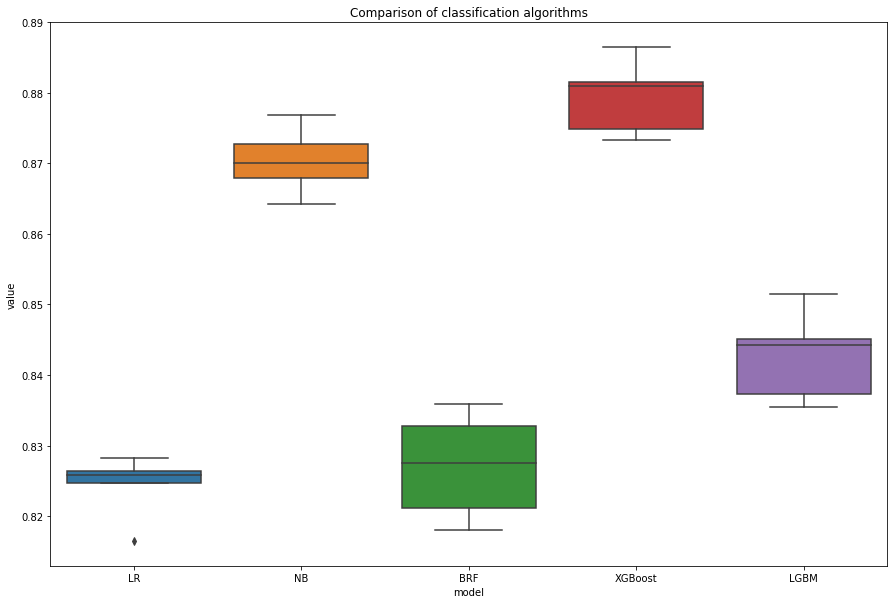

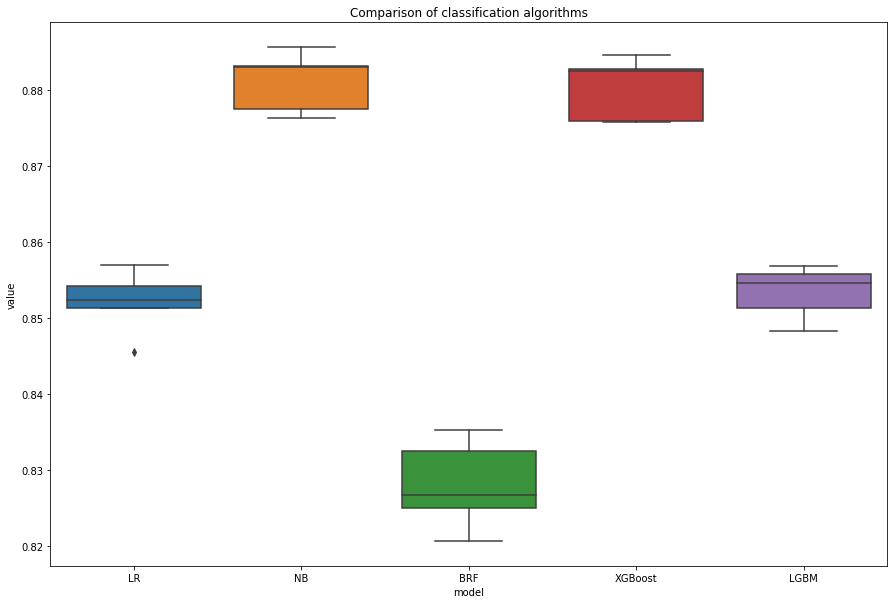

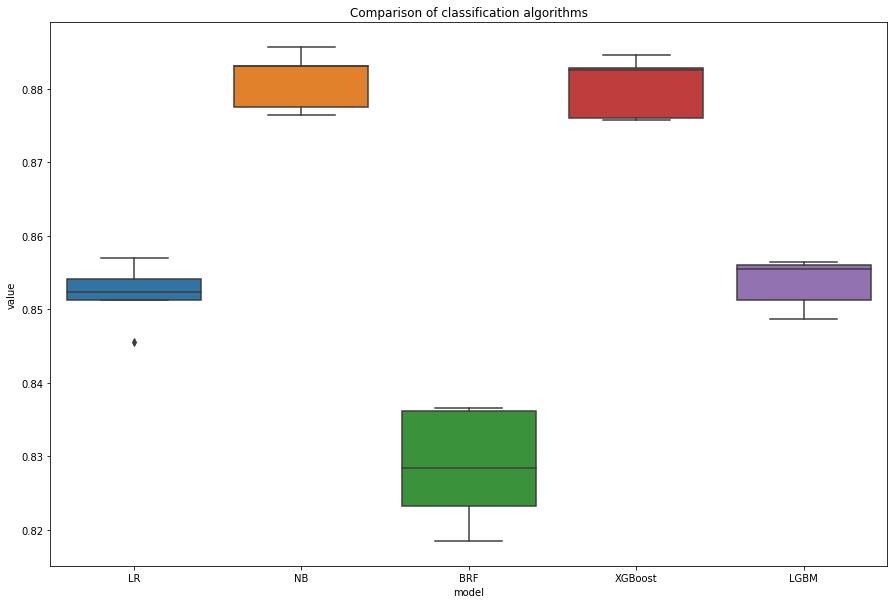

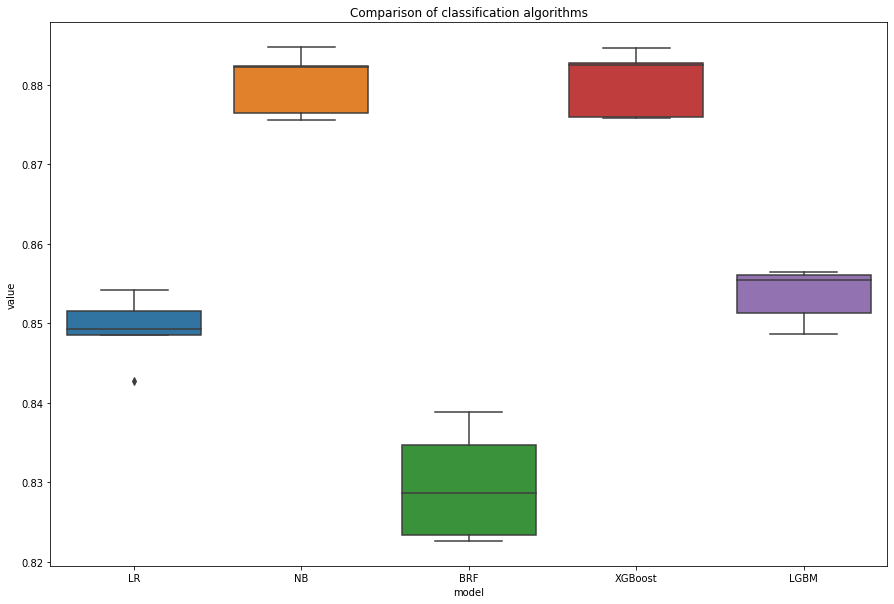

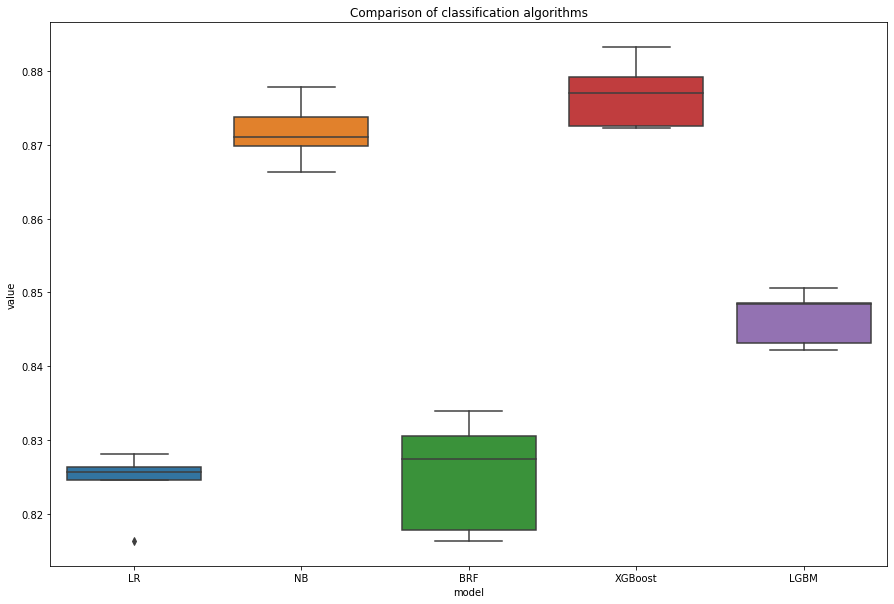

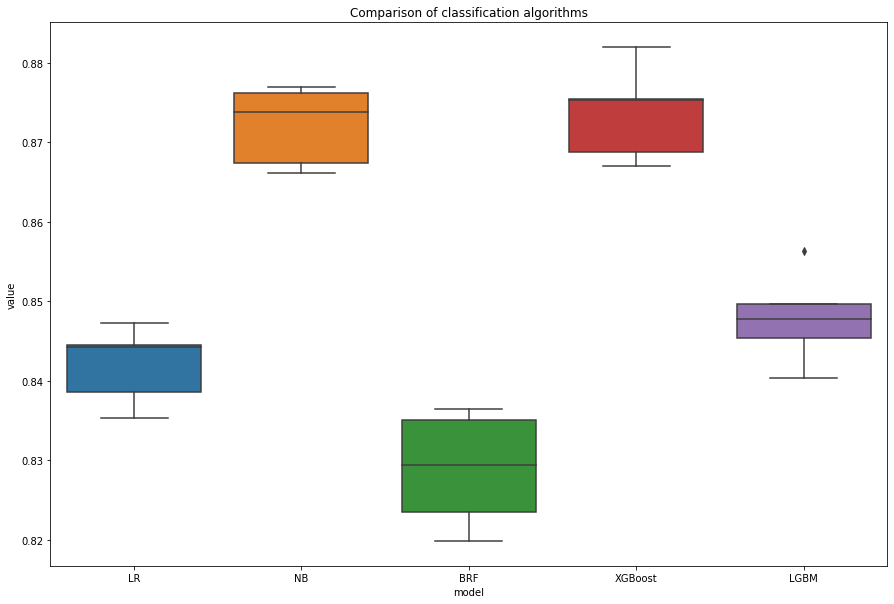

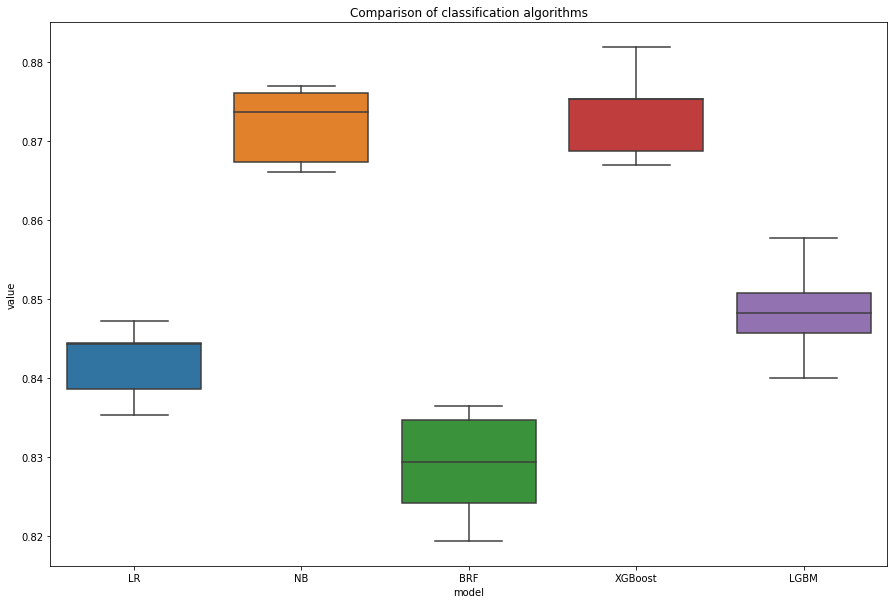

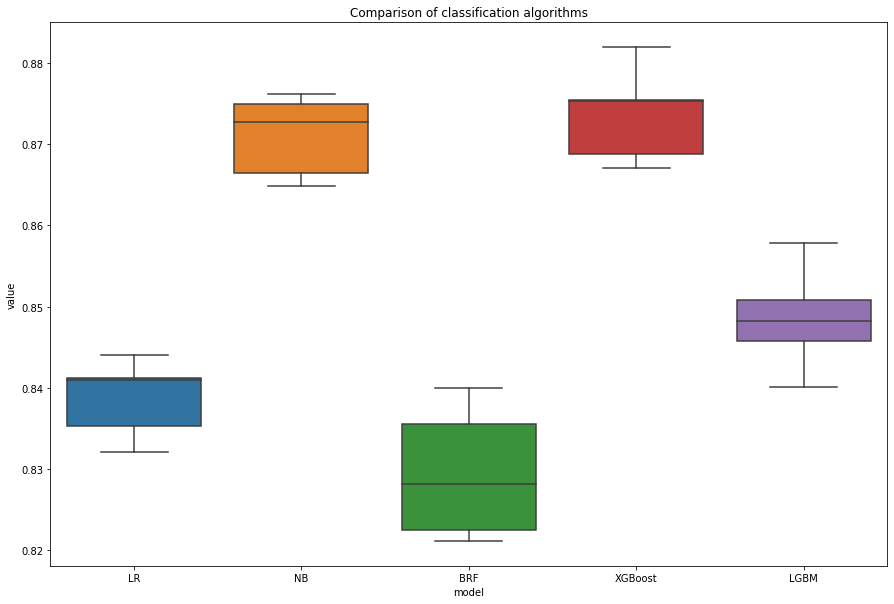

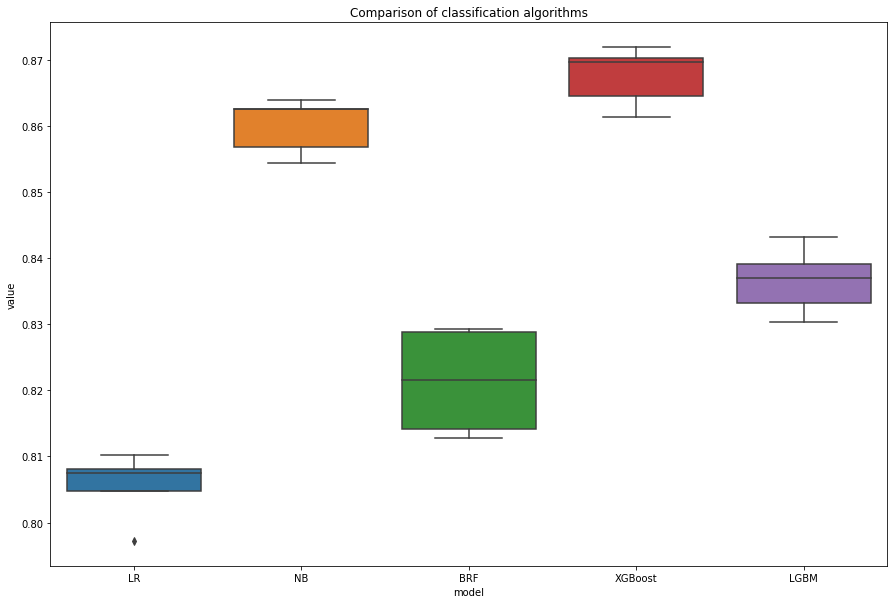

In [70]:
# Treinando classificadores a partir do metodo de normalizacao e da técnica de Feature Selection utilizada
train_results = dict()
for fs_name, feature_list in featurelist_dict.items():
    # obtain the dataset on the selected features
    # featurelist_dict['lasso_l1_nf-90']
    for normalization_type, normalized_dataset in train_dict.items():
        print(f'Training for {fs_name} x {normalization_type}...')
        train_results[(fs_name,normalization_type)] = classifiersTraining (
            features = normalized_dataset[feature_list], 
            tTarget  = y_train,
            model_label = f'{fs_name}-{normalization_type}'
        )
    # end for
# end for

#### Let's check the best normalization / standardization method to be used

* MM - MinMaxScaler
* SS - StandardScaler
* ND - PowerTransformer
* NM - normalize


In [71]:
# Concatenate all model training result dataframes
all_train_results = []
for key, df_list in train_results.items():
    (dataset_name, norm_type) = key
    df = df_list[1].reset_index()
    df  = df.rename(columns={"index": "model"})
    df['dataset_name'] = str(dataset_name)
    df['norm_type'] = str(norm_type)
    all_train_results.append(df)
# end for
all_train_results_df = pd.concat(all_train_results)
# for each combination of dataset_name, show the best performing model and norm_type
all_train_results_df.sort_values(by=['dataset_name', 'mean'], ascending=False, inplace=True)
all_train_results_df.groupby(by=['dataset_name']).head(2)

,model,mean,std,time_spent_s,dataset_name,norm_type
1,NB,0.888255,0.003780,64.933822,sbs_nf-196,MM
1,NB,0.888255,0.003779,62.568023,sbs_nf-196,SS
1,NB,0.886203,0.003568,47.991308,rf_nf-150,SS
1,NB,0.886203,0.003568,48.327754,rf_nf-150,MM
1,NB,0.881124,0.003594,60.176698,original_without_quasi_constant_nf-190,SS
1,NB,0.881124,0.003594,60.164287,original_without_quasi_constant_nf-190,MM
1,NB,0.888258,0.003795,65.843884,original_nf-200,MM
1,NB,0.888257,0.003794,63.090186,original_nf-200,SS
3,XGBoost,0.836055,0.002951,9.594576,mean_abs_diff_nf-150,MM
3,XGBoost,0.836055,0.002951,9.574913,mean_abs_diff_nf-150,SS


#### Comments

The best normalization / standardization type (with the highest `AUC score` on the majority of datasets) is **`MM - MinMaxScaler`**. 

The top3, best performing models are:

* Gaussian Naive Bayes (NB)
* XGboost
* LGBM

First, we will generate different submissions to Kaggle, based on these best-performing models, and save the obtained scores. 

Then we will invest time in tuning the best models.

## 4.5. Re-train the best-performing models, based on the whole dataset, and submit to Kaggle

In [72]:
def full_model_retrain(fs_name, X_full_MM, y_full, num_folds = 10, scoring = 'roc_auc'):
    gnb = GaussianNB()
    gnb_param = {'var_smoothing': np.logspace(0,-15, num=20)}
    gnb_cv = GridSearchCV(gnb, gnb_param, cv=num_folds, scoring=scoring, verbose=0, n_jobs=-1, return_train_score=True)
    gnb_cv.fit(X_full_MM, y_full)
    saveModel(f'GNB-{fs_name}', gnb_cv)

    xgb_class = XGBClassifier(max_depth=4, n_estimators=600, eta=0.1, booster='gbtree', subsample=0.4, verbosity=1, scale_pos_weight=8,
                  colsample_bytree=0.2, tree_method='gpu_hist', eval_metric='aucpr', use_label_encoder=False)
    xgb_class.fit(X_full_MM, y_full)
    saveModel(f'XGB-{fs_name}', xgb_class)

    lgbm_param = {
         'num_leaves': 18,
         'max_bin': 63,
         'min_data_in_leaf': 5,
         'learning_rate': 0.010614430970330217,
         'min_sum_hessian_in_leaf': 0.0093586657313989123,
         'feature_fraction': 0.056701788569420042,
          # 'lambda_l1': 0.060222413158420585,
          # 'lambda_l2': 4.6580550589317573,
         'min_gain_to_split': 0.29588543202055562,
         'max_depth': 49,
         'save_binary': True,
         'seed': 1337,
         'feature_fraction_seed': 1337,
         'bagging_seed': 1337,
         'drop_seed': 1337,
         'data_random_seed': 1337,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': 'auc',
         'is_unbalance': True,
         'boost_from_average': False
    }
    lgbm_class = lightgbm.LGBMClassifier(**lgbm_param)
    lgbm_class.fit(X_full_MM, y_full)
    saveModel(f'LGBM-{fs_name}', lgbm_class)

### 4.5.1. Retrain models based on full Kaggle train dataset and a predefined hyperparameter setting

In [73]:
# Treinando classificadores a partir do metodo de normalizacao e da técnica de Feature Selection utilizada
# Criando um objeto da classe MinMaxScaler().
scaler = MinMaxScaler()
# Aplicando a escala nas Features e capturando o resultado obtido
full_features = pd.concat([train.drop(["ID_code", "target"], axis = 1), test.drop(["ID_code", "target"], axis = 1)])
idx = features = full_features.columns.values
for df in [full_features]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
normalized_originalTestFeatures = scaler.fit_transform(full_features)
# Criando um DataFrame com os resultados obtidos.
normalized_originalTestFeatures_df = pd.DataFrame(data = normalized_originalTestFeatures, columns = full_features.columns)
y_full = pd.concat([y_train, y_test])

In [74]:
for fs_name, feature_list in featurelist_dict.items():
    print(f'Full training for {fs_name} x MM...')
    X_full_MM = normalized_originalTestFeatures_df[feature_list]
    full_model_retrain(fs_name, X_full_MM, y_full)
# end for

Full training for information_gain_nf-150 x MM...


KeyboardInterrupt: 

### 4.5.2. Predict values for Kaggle test dataset

For each combination of model, normalization type and feature subset, we will generate a Kaggle CSV submission file and we will manually submit it to Kaggle, recording the public score obtained.

In [76]:
import os

df_val = df_test.drop(columns=['ID_code'])
idx = features = df_val.columns.values
for df in [df_val]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
# end for
normalized_originalValFeatures = scaler.fit_transform(df_val)
# Criando um DataFrame com os resultados obtidos.
normalized_originalValFeatures_df = pd.DataFrame(data = normalized_originalValFeatures, columns = df_val.columns)

for file in os.listdir("../input/santandercustomertransactionv1models"):
    if file.endswith(".sav"):
        if kaggle:
            model_filename = os.path.join("../input/santandercustomertransactionv1models", file)
        else:
            model_filename = os.path.join(".", file)
        # end if
        print(f'Processing model {model_filename}...')
        model_basename = model_filename[model_filename.rfind(os.path.sep)+1:model_filename.rfind('.')]
        model = loadModel(model_basename, fold="../input/santandercustomertransactionv1models/")
        dataset_name = model_filename[model_filename.find('-')+1:model_filename.rfind('.')]
        print(f'Prediction for dataset_name = {dataset_name}')
        feature_list = featurelist_dict[dataset_name]
        df_val_subset = normalized_originalValFeatures_df[feature_list]
        # Salvando as previsões feitas pelo classificador para o conjunto de teste em um arquivo CSV
        pd.DataFrame({
            'ID_code'    : testID,
            'target': model.predict_proba(df_val_subset)[:, 1]
        }).to_csv(f'pred-{model_basename}.csv', index = False)
    # end if
# end for

Processing model ../input/santandercustomertransactionv1models/LGBM-lasso_l1_nf-90.sav...
Modelo carregado!
Prediction for dataset_name = lasso_l1_nf-90


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


NotFittedError: Estimator not fitted, call fit before exploiting the model.

### 4.5.3. Evaluate Kaggle score values (typed into s csv file after manual submission)

We can see, in the Kaggle results below (v1), that the best-performing models/datasets are:

* XGB and GNB models
* original_nf-200, sbs_nf-196, anova_nf-150, and rf_nf-150

**We will now try to tune the hyperparameters of each model, to generate a new set of classifiers and a new set of Kaggle predictions (v2).**

In [81]:
if not kaggle:
    kaggle_v1_df = pd.read_csv('kaggle_model_scores_v1.csv')
else:
    kaggle_v1_df = pd.read_csv('../input/santandercusttransactionmydata/kaggle_model_scores_v1.csv')
# end if
kaggle_v1_df.sort_values(by=['public_score'], ascending=False)

,model_name,public_score
8,pred-GNB-original_nf-200,0.88731
10,pred-GNB-sbs_nf-196,0.88724
11,pred-XGB-sbs_nf-196,0.88677
7,pred-XGB-original_nf-200,0.88586
17,pred-GNB-anova_nf-150,0.88562
13,pred-XGB-rf_nf-150,0.88560
14,pred-GNB-rf_nf-150,0.88491
16,pred-XGB-anova_nf-150,0.88469
5,pred-GNB-original_without_quasi_constant_nf-190,0.87945
4,pred-XGB-original_without_quasi_constant_nf-190,0.87822


## 4.6. Tune the hyperparameters of the best model(s) and re-submit to Kaggle

After some preliminary tests (above), we observed that the best models and feature subsets are:

* XGB and GNB models
* original_nf-200, sbs_nf-196, anova_nf-150, and rf_nf-150

**We will now try to tune the hyperparameters of each model, to generate a new set of classifiers and a new set of Kaggle predictions (v2).**


### 4.6.1. XGBoost Classifier

We will look for the best hyper-parameters to create a model with the Xgboost algorithm.

### XGBoost using Optuna

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API.
The code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

**As basic concepts, We use the terms study and trial as follows**:

* **Study** : optimization based on an objective function;
* **Trial** : a single execution of the objective function.


The following optimization function uses XGBoostClassifier model, so it takes the following arguments:

* the data
* the target
* number of trials (How many executions will be done)

And returns:

* objective value: AUC_PR (suits best than AUC when target data is heavily imbalanced)

Notes:

* We used some XGBoostRegressor hyperparameters from Xgboost official site;
* Also we used `early_stopping_rounds` to avoid overfiting and to speedup the training process
* We can use the GPU, or you can comment the first param argument (the training process will takes a lot of time by only using the cpu)

References:
* https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407
* https://www.kaggle.com/code/hamzaghanmi/xgboost-catboost-using-optuna?scriptVersionId=94510532
* https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc

In [ ]:
import optuna
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold, cross_validate, train_test_split, cross_val_score

def objective(trial, data, target, cv, scoring, use_cv):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.6, random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    optuna_xgb_param = {
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
        #'eta': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02, 0.03]),
        'n_estimators': [340, 600, 10000],
        'max_depth': trial.suggest_categorical('max_depth', [4,5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'booster': 'gbtree',
        'scale_pos_weight': 8,
        'eval_metric': 'aucpr', 
        #'eval_metric': 'auc', 
        'use_label_encoder': False,
        'nthread': 12, 
        "objective": "binary:logistic",
        "silent": 1,
    }
    if use_cv:
        # Perform CV
        xgb_model = XGBClassifier(**optuna_xgb_param)
        scores = cross_val_score(xgb_model, data, target, cv=cv, scoring=scoring, n_jobs=-1)
        return scores.mean()
    else:
        xgb_model = xgb.XGBClassifier(**param)
        # Add a callback for pruning.
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-aucpr")
        bst = xgb.train(param, dtrain, evals=[(dtest, "validation")], callbacks=[pruning_callback], early_stopping_rounds=10)
        # Kaggle accepts probabilities as answer, so
        # predict will return the probability of class == 1, how to set threshold (TODO)
        preds = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
        pred_labels = preds
        ### pred_labels = np.rint(preds)
        # model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
        # auc = roc_auc_score(test_y, pred_labels)
        aucpr = average_precision_score(test_y, pred_labels)
        return aucpr

In [ ]:
# treat all python warnings as lower-level "ignore" events
import warnings
warnings.filterwarnings("ignore")

In [ ]:
optuna.logging.set_verbosity(optuna.logging.FATAL)

### Let's start optimizing the hyperparameters

Note that the objective of our fuction is to **maximize the `AUC-PR`** that's why I set direction='maximize'.

#### Note:

* n_trials (number of executions) can be modified

* we will test different values for the learning rate parameter `eta`, as well as other xgb parameters.

In [ ]:
xgb_param = {
        'tree_method': optuna.distributions.CategoricalDistribution(['gpu_hist']),  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': optuna.distributions.LogUniformDistribution(1e-3, 10.0),
        'alpha': optuna.distributions.LogUniformDistribution(1e-3, 10.0),
        'colsample_bytree': optuna.distributions.CategoricalDistribution([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': optuna.distributions.CategoricalDistribution([0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'eta': optuna.distributions.LogUniformDistribution(1e-8, 1.0),
        #'eta': optuna.distributions.CategoricalDistribution([0.008,0.01,0.012,0.014,0.016,0.018, 0.02, 0.03]),
        'n_estimators': optuna.distributions.CategoricalDistribution([340, 600, 10000]),
        'max_depth': optuna.distributions.CategoricalDistribution([4,5,7,9,11,13,15,17]),
        'random_state': optuna.distributions.CategoricalDistribution([2020]),
        'min_child_weight': optuna.distributions.IntUniformDistribution(1, 300),
        'booster': optuna.distributions.CategoricalDistribution(['gbtree']),
        'scale_pos_weight': optuna.distributions.CategoricalDistribution([8]),
        'eval_metric': optuna.distributions.CategoricalDistribution(['aucpr']), 
        #'eval_metric': 'auc', 
        'use_label_encoder': optuna.distributions.CategoricalDistribution([False]),
        'nthread': optuna.distributions.CategoricalDistribution([12]), 
        "objective": optuna.distributions.CategoricalDistribution(["binary:logistic"]),
    }

In [ ]:
use_optimize_func = False
timeout = 1800 # 600 seconds == 10 min for each model

In [ ]:
%%time
df_study_dict = dict()
study_dict = dict()
# IMPORTANTE! Instanciando um objeto da StratifiedKFold para criar os folds, pois ha desbalanceamento do target
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for fs_name, feature_list in featurelist_dict.items():
    if fs_name in ['original_nf-200', 'sbs_nf-196']:  # , 'anova_nf-150', 'rf_nf-150']:
        print(f'Tuning XGB model for {fs_name} x MM...')
        data = normalized_originalTestFeatures_df[feature_list]
        target = y_full
        # obtain the dataset on the selected features
        # train_dict['MM', fs_name]  # normalization_type, normalized_dataset
        for normalization_type, normalized_dataset in train_dict.items():
            model_label = f'{fs_name}-MM'
            study = optuna.create_study(direction='maximize')
            if use_optimize_func:
                # Wrap the Optuna objective inside a lambda and call objective inside it
                func = lambda trial: objective(trial, data, target, cv=kfold, scoring='average_precision', use_cv=True)
                study.optimize(func, n_trials=50)
            else:
                xgb_model = XGBClassifier()
                optuna_search = optuna.integration.OptunaSearchCV(xgb_model, xgb_param, cv=kfold, n_jobs=-1, random_state=42, study=study, timeout=timeout)  #, enable_pruning=True)
                optuna_search.fit(data, target)
                y_pred = optuna_search.predict(data)
            # end if
            print('Number of finished trials:', len(study.trials))
            print('Best trial:', study.best_trial.params)
            
            study_dict[model_label] = study
            df_study_dict[model_label] = study.trials_dataframe()
        # end if
    # end for
# end for

In [ ]:
# Optuna output removed due to excessive output

In [ ]:
df_study_dict.keys()

In [ ]:
df_study_dict['original_nf-200-MM']

### Let's do some Quick Visualization for Hyperparameter Optimization Analysis

Optuna provides various visualization features in optuna.visualization to analyze optimization results visually.

In [ ]:
# plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study_dict['original_nf-200-MM'])

In [ ]:
optuna.visualization.plot_optimization_history(study_dict['sbs_nf-196-MM'])

In [ ]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study_dict['original_nf-200-MM'])

In [ ]:
optuna.visualization.plot_slice(study_dict['sbs_nf-196-MM'])

### Let's create a XGBoostClassifier model with the best hyperparameters for each of the two datasets (`sbs_nf-196-MM` and `original_nf-200-MM`)

In [ ]:
best_xgb_trial_params = dict()

best_xgb_trial_params['sbs_nf-196-MM'] = {'tree_method': 'gpu_hist', 'lambda': 5.852983163624425, 'alpha': 0.1550111155371834, 
                                          'colsample_bytree': 1.0, 'subsample': 0.9, 'eta': 0.025334831995211547, 
                                          'n_estimators': 10000, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 43, 
                                          'booster': 'gbtree', 'scale_pos_weight': 8, 'eval_metric': 'aucpr', 
                                          'use_label_encoder': False, 'nthread': 12, 'objective': 'binary:logistic'}

best_xgb_trial_params['original_nf-200-MM'] = {'tree_method': 'gpu_hist', 'lambda': 0.0010001992411276593, 'alpha': 0.6641490292943272, 
                           'colsample_bytree': 0.3, 'subsample': 0.7, 'eta': 0.016423404013017992, 'n_estimators': 340, 
                           'max_depth': 15, 'random_state': 2020, 'min_child_weight': 34, 'booster': 'gbtree', 
                           'scale_pos_weight': 8, 'eval_metric': 'aucpr', 'use_label_encoder': False, 'nthread': 12, 
                           'objective': 'binary:logistic'}

 ## 5. Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set (25%) and reviewing the evaluation metrics.

All of the evaluation metrics we have seen above (from Optuna results and graphs) are cross-validated results based on the training set (75%). Now, using our final trained model, we will predict the test / hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [ ]:
def holdout_model_retrain(fs_name, X_train, y_train, X_test, y_test):
    xgb_class = XGBClassifier(**best_xgb_trial_params[fs_name])
    # Fits the model on the training data, and evaluates the metrics based on the test/validation data
    xgb_class.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    saveModel(f'holdout-XGB-{fs_name}', xgb_class)
    return xgb_class

In [ ]:
classifierXGB = dict()
for fs_name in best_xgb_trial_params.keys():
    print(f'****** Processing dataset {fs_name}...')
    classifierXGB[fs_name] = holdout_model_retrain(fs_name, X_train, y_train, X_test, y_test)
# end for

In [ ]:
# Calculando a acurácia, ROC AUC e AUC-PR do modelo para os conjuntos de dados de treino e de validacao
for fs_name in best_xgb_trial_params.keys():
    print(f'****** Processing dataset {fs_name}...')
    
    print('***** Train metrics: *****')
    predTrain = classifierXGB[fs_name].predict(X_train)
    predProbTrain = classifierXGB[fs_name].predict_proba(X_train)[:,1]
    df_metrics_train = getClassificationMetrics(y_train, predProbTrain, labelPositive = 1, labelNegative = 0)
    display(df_metrics_train)
    cm = confusionMatrix(y_train, predTrain, labelPositive = 1, labelNegative = 0, classError = False)
    plotConfusionMatrix(cm, labels=['0', '1'], title=f'{fs_name} - Train')
    
    plt.figure(figsize=(10,10))
    sns.regplot(y_train, predTrain, fit_reg=True, scatter_kws={"s": 100})
    
    print('***** Holdout metrics: *****')
    predValidation = classifierXGB[fs_name].predict(X_test)
    predProbValidation = classifierXGB[fs_name].predict_proba(X_test)[:,1]
    df_metrics_validation = getClassificationMetrics(y_test, predProbValidation, labelPositive = 1, labelNegative = 0)
    display(df_metrics_validation)
    cm = confusionMatrix(y_test, predValidation, labelPositive = 1, labelNegative = 0, classError = False)
    plotConfusionMatrix(cm, labels=['0', '1'], title=f'{fs_name} - Validation')
    
    plt.figure(figsize=(10,10))
    sns.regplot(y_test, predValidation, fit_reg=True, scatter_kws={"s": 100})
# end for

#### Comments

We conclude this hold-out analysis, finding out that the XGBoost model obtained a hold-out score of:

**Dataset sbs-196-MM**

F1      0.533644

ROC AUC 0.890678

AUC PR  0.594915

**Dataset original-200-MM**

F1      0.513706

ROC AUC 0.867314

AUC PR  0.536523

## 6. Finalize Model for Deployment

Model finalization is the last step in the experiment. We started the machine learning workflow by normalizing the dataset, then generating feature importance scores and distinct datasets with different subsets of features.

The next step consisted in testing a couple of sklearn models over these different datasets, comparing all models using the `AUC` metric and shortlisting a few candidate models to perform hyperparameter tuning. This workflow led us to the best model for use in making predictions on new and unseen data : `xgboost`. 

In this last step, we will fit the model onto the complete dataset *including the test/hold-out sample (25% in our case)*. The purpose of this step is to train the model on the complete dataset before it is deployed to predict the Kaggle validation (`df_test`) set.


**Assembling the whole dataset to perform a full final model train on all available data (`X_train` and `X_test`)**

In [ ]:
# Treinando classificadores a partir do metodo de normalizacao e da técnica de Feature Selection utilizada
# Criando um objeto da classe MinMaxScaler().
scaler = MinMaxScaler()
# Aplicando a escala nas Features e capturando o resultado obtido
full_features = pd.concat([train.drop(["ID_code", "target"], axis = 1), test.drop(["ID_code", "target"], axis = 1)])
idx = features = full_features.columns.values
for df in [full_features]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
normalized_originalTestFeatures = scaler.fit_transform(full_features)
# Criando um DataFrame com os resultados obtidos.
normalized_originalTestFeatures_df = pd.DataFrame(data = normalized_originalTestFeatures, columns = full_features.columns)
y_full = pd.concat([y_train, y_test])

In [ ]:
def finalize_model_retrain(fs_name, X_full_MM, y_full):
    xgb_class = XGBClassifier(**best_xgb_trial_params[fs_name])
    xgb_class.fit(X_full_MM, y_full)
    saveModel(f'best-XGB-{fs_name}', xgb_class)
    return xgb_class

In [ ]:
final_classifier_XGB = dict()

for fs_name, feature_list in featurelist_dict.items():
    if fs_name + '-MM' in best_xgb_trial_params.keys():
        print(f'Full training for {fs_name} x MM...')
        X_full_MM = normalized_originalTestFeatures_df[feature_list]
        final_xgb_model = finalize_model_retrain(fs_name + '-MM', X_full_MM, y_full)
        final_classifier_XGB[f'{fs_name} x MM'] = final_xgb_model
    # end if
# end for

## 7. Submission

In [ ]:
# sample_submission format
# ID_code,target
# test_0,0
# test_1,1
# test_2,0
# etc.

In [ ]:
df_val = df_test.drop(columns=['ID_code'])
idx = features = df_val.columns.values
for df in [df_val]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
# end for
normalized_originalValFeatures = scaler.fit_transform(df_val)
# Criando um DataFrame com os resultados obtidos.
normalized_originalValFeatures_df = pd.DataFrame(data = normalized_originalValFeatures, columns = df_val.columns)

In [ ]:
# Fazendo previsoes para o conjunto de teste, considerando diferentes subconjuntos de features e normalizacao MM
for fs_name, feature_list in featurelist_dict.items():
    if fs_name + '-MM' in best_xgb_trial_params.keys():
        print(f'Kaggle prediction for {fs_name} x MM...')
        X_kaggle = normalized_originalValFeatures[feature_list]
        final_model = final_classifier_XGB[f'{fs_name} x MM']

        # Salvando as previsões feitas pelo classificador para o conjunto de teste em um arquivo CSV
        pd.DataFrame({
            'ID_code'    : testID,
            'target': final_model.predict_proba(X_kaggle)[:, 1]
        }).to_csv(f'final-pred-{fs_name}-MM.csv', index = False)
    # end if
# end for

We conclude this analysis, finding out that the XGBoost algorithm generated the model with the best score for ROC AUC metric. The score achieved for the test datasets for the ROC AUC, as assessed by Kaggle, was:

Dataset : Kaggle public score (ROC AUC for the test data)
* Information gain_nf-150 : 0.87631
* final-pred-mean_abs_diff_nf-150-MM : 0.83892
* final-pred-disp_ratio_nf-150-MM : 0.85341
* final-pred-lr_nf-150-MM : 0.80854
* final-pred-anova_nf-150-MM : 0.88891
* final-pred-rf_nf-150-MM : 0.88782
* final-pred-sbs_nf-196-MM : 0.88936, then 0.89041
* final-pred-original_nf-200-MM : 0.87310, then 0.89044
* final-pred-original_without_quasi_constant_nf-190-MM : 0.88187
* final-pred-lasso_l1_nf-90-MM : 0.86930

### The highest score obtained with the submissions above was 0.89044 with XGBoost and original_nf-200-MM dataset.

## 8. Observing the target values *vs.* feature values using PCA

In [ ]:
y_train.sum() / y_train.count()

In [ ]:
y_test.sum() / y_test.count()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

def plot_pca_values_with_target(X, y, title):
    scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    rob_scaler = RobustScaler()
    pca2D = PCA(n_components=2)
    pipe = Pipeline([('mm_scaler', scaler), ('pca', pca2D)])
    Xt = pipe.fit_transform(X)

    plt.figure(figsize=(8,6))
    plt.title(title)
    df_pca = pd.concat([pd.DataFrame(data=Xt, columns=['PC1', 'PC2']), y.to_frame()], axis=1)
    sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="target", style='target')

In [ ]:
plot_pca_values_with_target(X_train, y_train, 'Real train data')

In [ ]:
for fs_name, feature_list in featurelist_dict.items():
    if fs_name + '-MM' in best_xgb_trial_params.keys():
        X_train_MM = train_dict['MM'][feature_list]
        predTrain = pd.Series(data=final_classifier_XGB[fs_name + ' x MM'].predict(X_train_MM), name='target')
        plot_pca_values_with_target(X_train, predTrain, f'Predicted train data - {fs_name}')
    # end if
# end for

In [ ]:
plot_pca_values_with_target(X_test, y_test, 'Validation data')

In [ ]:
for fs_name, feature_list in featurelist_dict.items():
    if fs_name + '-MM' in best_xgb_trial_params.keys():
        X_val_MM = normalized_originalValFeatures_df[feature_list]
        predTrain = pd.Series(data=final_classifier_XGB[fs_name + ' x MM'].predict(X_val_MM), name='target')
        plot_pca_values_with_target(X_train, predTrain, f'Predicted test data - {fs_name}')
    # end if
# end for

#### Comment

It is difficult to establish a decision frontier based on the 2D PCA transformation of the dataset.

## 9. Exploring the rounding thrshold of the predicted target values

Let's test Kaggle submissions with different thresholds when rounding the predicted `target` value, instead of submitting the `predict_proba` value to Kaggle.

In [ ]:
# Fazendo previsoes para o conjunto de teste, considerando diferentes subconjuntos de features e normalizacao MM
for threshold in np.arange(0.1, 0.9, 0.1):
    for fs_name, feature_list in featurelist_dict.items():
        if fs_name + '-MM' in best_xgb_trial_params.keys():
            print(f'Kaggle prediction for {fs_name} x MM and threshold = {threshold}...')
            final_model = final_classifier_XGB[f'{fs_name} x MM']

            df_val_subset = normalized_originalValFeatures_df[feature_list]
            # Salvando as previsões feitas pelo classificador para o conjunto de teste em um arquivo CSV
            rounder = lambda t: 1 if t >= threshold else 0
            vround = np.vectorize(rounder)
            predicted = vround(final_model.predict_proba(df_val_subset)[:, 1])
            pd.DataFrame({
                'ID_code'    : testID,
                'target': predicted
            }).to_csv(f'final-pred-{fs_name}-MM-thres-{threshold}.csv', index = False)
        # end if
    # end for
# end for

In [ ]:
df_kaggle_threshold = pd.read_csv('kaggle_model_threshold_scores.csv')
df_kaggle_threshold

#### Comment

As we can see, the rounding of the `target` value, following a threshold between `0.1` and `0.8`, did not improve the scores. 

It is better to stick with the `predict_proba` float output as predicted `target` values.